# PGs generation, detection & recognition via learning delays

In [3]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

INFO       Cache size for target "cython": 2112 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\camil\.cython\brian_extensions" directory. [brian2]


On s'intéresse ici à la génération, la détection et l'apprentissage de patterns temporels grâce à l'apprentissage des délais de manière à ce qu'un pattern temporel d'intéret s'articule en groupe polychrone (PG). Un groupe polychrone est définit par un groupe de neurone qui déchargent de manière asycnhrone, à différents moments, mais qui, grâce à leurs délais, transmettent l'information à un neurone post synaptique de façon sychrone.

L'idée ici est dans un premier temps de réaliser un modèle génératif de pattern temporel et un modèle de détection de groupes polychrones en Brian. Pour celà, on utilise un réseau de neurone à spike de trois couches : 
- la première couche est constituée de neurones du SpikeGeneratorGroup A et sert à la génération.
- la deuxième couche est constituée de neurones appartenant au NeuronGroup B et sert à la génération. 
- la troisième couche est constituée de neurones appartenant au NueronGroup C et sert à la détection.

Les neurones de la couche A vont émettrent un spike à un moment donné de la simulation. Chaque neurone de cette couche projette sur au moins trois neurones de la couche B, selon un certain poid et un certain delais. Si un neurone de la couche A spike, alors les neurones de la couche B sur lesquels il projette vont emettrent un spike (en fonction de leur poid et de leur délai). Tous les neurones de la couche B qui déchargent en réponse au spike du neurone de la couche A consitituent un groupe polychrone. 
Avec cette organisation, on génère un rasterplot artificiel (actvité des neurones de la couche B) dans lequel on voudrait détecter des groupes polychrones. Les spikes appartenant à un même groupe sont déterminés en fonction du neurone de la couche A qui a engendré leur décharge. L'activité de la couche B correspond donc à notre entrée et l'activité des neurones de la couche A correspond à notre ground truth, ce que l'on voudrait détecter. Un spike d'un neurone dans la couche A correspond à l'occurence d'un groupe polychrone. 
Puisque l'on connait les connections a->b, les poids et les délais, il est facile d'organiser un groupe de neurone en groupe polychrones en réalisant une troisièmpe couche, équivalente à la couche a. On construit des connections b->c de la même manière que a->b, avec les mêmes poids. On ajuste les délais de sorte à ce que les spikes d'un groupe de neurones polychrone arrivent de façon synchrone sur un neurone de la couche c et induisent leur décharge. Lorsqu'un neurone c spike ça veut dire que les neurones projettant sur lui spike avec une certaine séquence temporelle. On detecte donc une séquence temporelle d'intéret à un moment dans le temps. En récupérant les délais on peut connaitre cette séquence temporelle. 

### variable definition

In [3]:
Ni = 3 #nb de PGs différents
Nj = 10 #nb d'adresses en entrée 
n_pattern = 50 # nb d'occurrence des PGs 
duration = 10*second

PGs_pattern = {}
PGs_id_tps = {}
detection = {}
state_b = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [4]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, 3, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []
nn_j = []
W = []
n_j_quick =[]

for k in range(Ni) : 
    n_j = (np.random.randint(3, Nj, size = 1)) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    W.append(list(np.random.rand(int(n_j))))
    W[k] /= sum(W[k])
    i_syn_bruit = np.linspace
n_syn = sum(n_syn) 

# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 

### NN simulation for PGs generation and detection

In [588]:
def generator_terminator(nn_j, i_syn, i_indices, i_temps):
    
    start_scope()

    e_in = []
    e_true_t= []
    e_true_i= []
    e_true = []  
    import time

    start = time.time()

# --- generation de e_in ----------------------------------------------------------------------------------------------------------
    
    for i in range(n_pattern) :    
        
        a = SpikeGeneratorGroup(Ni, [i_indices[i]], [i_temps[i]/ms*msecond])
        a_spike = SpikeMonitor(a)
    
        b = NeuronGroup(Nj, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.02000*volt',
                        reset= 'v = 0*volt',
                       method = 'exact')
        b.v = 0*volt
        b.tau = 0.001*second
        b_spike = SpikeMonitor(b)
        #b_state = StateMonitor(b, 'v', record = True)

        s = Synapses(a,b, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
        for k in range(Ni):
            s.connect(i = k , j = i_syn[k])
            s.w[k,:] = W[k]*20 
            
        s.delay[:,:] = delay
    
    # --- generation de e_true/detectorrr_terminator ----------------------------------------------------------------------------------
       
        c =  NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.005*volt',
                        reset= 'v = 0*volt',
                        method = 'exact')
    
        c.v = 0*volt
        c.tau = 0.001*second
        c_spike = SpikeMonitor(c)
    
        syn = Synapses(b,c, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
        for k in range(Ni):
            syn.connect(i = i_syn[k], j = k)         
            syn.w[:,k] = W[k]
            syn.delay[:,k] = max(s.delay[k,:])-s.delay[k,:]
    
    
        net_g = Network(collect())
        net_g.add(a, a_spike, b, b_spike, c, c_spike, s, syn)
        net_g.run(duration)
    
        print('generation : ', time.time() - start)
        
        
        
    # --- stock dans des variables ----------------------------------------------------------------------------------------------------
        
        PGs_id_tps[i] = (a_spike.t, a_spike.i) # generator
        PGs_pattern[i] = (b_spike.t, b_spike.i) # generator
        detection[i] = (c_spike.t, c_spike.i) # generator, detector (-max(syn.delay[:,[c_spike.i]]) pour que ce soit le premier spike que l'on detecte, peut etre pas essentiel
        
        print('stock : ', time.time() - start)
        
        for k in range(len(PGs_pattern[i][0])):
            e_in.append(tuple((round(PGs_pattern[i][0][k]*1000/second), PGs_pattern[i][1][k])))
    
        for ele in detection[i][0] : 
            e_true_t.append(ele)
        for ele in detection[i][1] : 
            e_true_i.append(ele)

    for i in range(len(e_true_i)):
        e_true.append(tuple((e_true_t[i],e_true_i[i])))
        
        
    e_in.sort(key=lambda y: y[0]) #pour trier de tmin à tmax
    e_true.sort(key=lambda y: y[0]) #pour trier de tmin à tmax
        
    return s, syn, PGs_id_tps, PGs_pattern, detection, e_in, e_true


# --- visualisation -----------------------------------------------------------------------------------------------

    # --- de l'activité ---------------------------------------------------------------------------------------------------------

def plot_generator(lolo) : 
    plt.figure(figsize=(10,5))
    for i in range(n_pattern) :
        plt.scatter(lolo[i][0], lolo[i][1], color = color_dict[i_indices[i]], marker = "|")
        
    # --- des connections ----------------------------------------------------------------------------------------------------
        
def visualise_connectivity(s): # ajouter les delays
    Ns= len(s.source)
    Nt = len(s.target)
    figure(figsize=(15,8))
    
    subplot(141)
    plot(zeros(Ns), arange(Ns), 'ok', ms=7)
    plot(ones(Nt), arange(Nt), 'ok', ms=7)
    for i, j in zip(s.i, s.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    
    subplot(142)
    plot(s.i, s.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(143) 
    scatter(s.i, s.j, s.w*30 )
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(144) 
    scatter(s.i, s.j, s.delay*300)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [74]:
for i in s.i :
    print(i==0)

True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False


In [562]:
start_scope()
s, syn, PGs_id_tps, PGs_pattern, detection, e_in, e_true = generator_terminator(nn_j, i_syn, i_indices, i_temps)

ValueError: Provided values do not match the size of the indices, 9 != 5.

In [125]:
s, syn, a_spike, b_spike, e_in, e_true = quick_generator()

ind : [0 0 2 2 0 2 1 0 2 0 2 1 0 2 0 1 1 1 1 1 1 0 1 2 0 1 1 2 0 0]
t"emps :  [9.21159962 3.46478976 5.87474962 1.34911123 0.06885697 4.57112061
 1.48630186 4.0046958  5.7618321  6.13960122 6.24862981 6.00654121
 3.64497746 2.34887948 0.87078044 4.5503892  9.56548989 8.46381932
 7.87025396 1.11590886 0.66889825 0.01264664 6.6417244  4.78197632
 1.66433704 1.51068597 2.19547024 0.25870783 8.47477374 1.85253906] s
generation :  9.779600858688354


Text(0.5, 1.0, 'occurence of PGs')

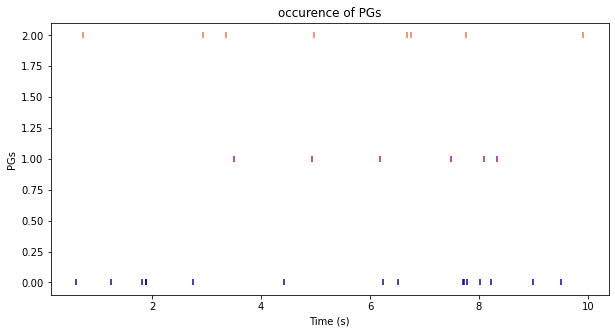

In [7]:
occurence_PGs = plot_generator(PGs_id_tps)
xlabel('Time (s)')
ylabel('PGs')
title('occurence of PGs')

Text(0.5, 1.0, 'e_in')

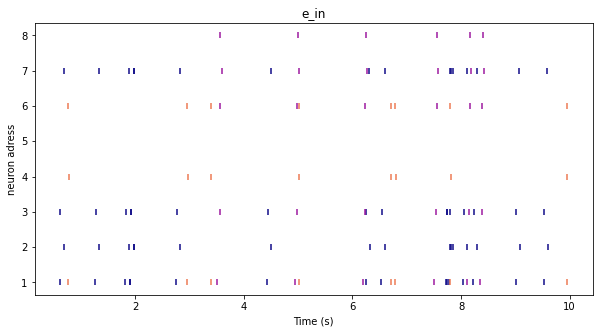

In [457]:
raster_plot = plot_generator(PGs_pattern)
xlabel('Time (s)')
ylabel('neuron adress')
title('e_in')

Text(0.5, 1.0, 'detection of PGs')

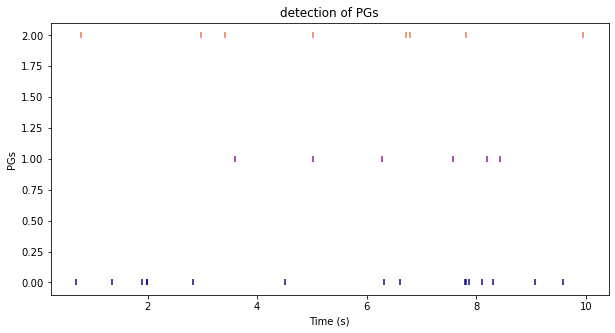

In [9]:
detection_PGs = plot_generator(detection)
xlabel('Time (s)')
ylabel('PGs')
title('detection of PGs')

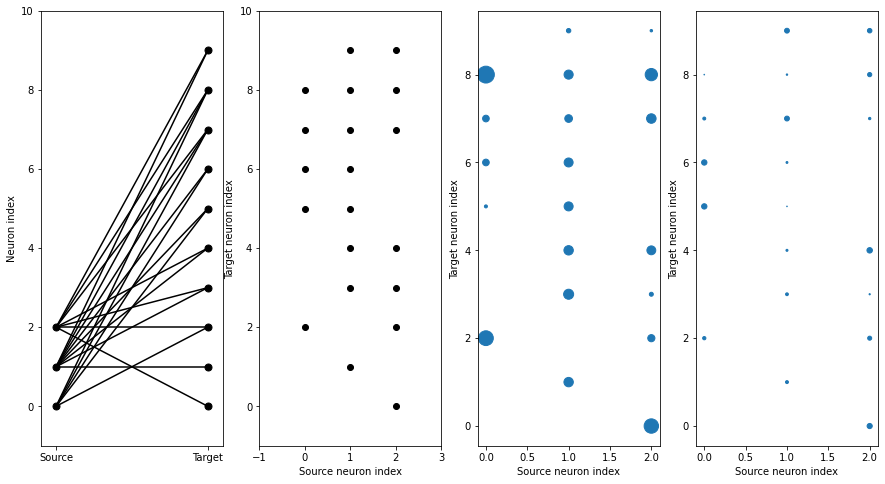

In [589]:
visualise_connectivity(s)

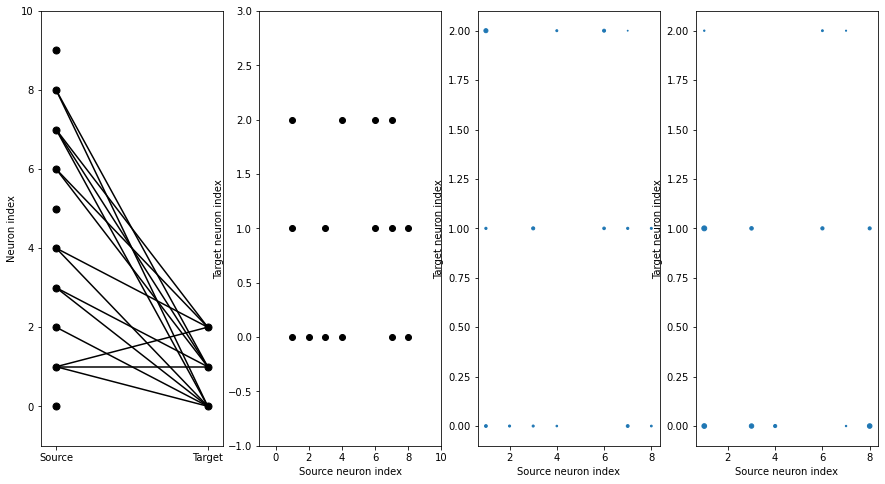

In [11]:
visualise_connectivity(syn)

ici, ce sont les connections b->c qui déterminent les neurones impliqués dans un PG, les poids sont donc obsolètes pour la détection des PGs. Ils décervent même un peu, par exemple pour la détection du PG 2, la somme des poids est faible et donc la synchronisation des décharges des neurones le composant ne permet pas de dépasser le seuil de 0.02, j'ai du l'abaisser à 0.01. 
Il faudrait plutot faire une couche de détections où tous les b connectent tous les c et où les poids sont importants pour les neurones où a->c existe et faibles pour les connections où a->c n'existe pas. (ici b->c n'existe que si a->c existe, les poids ne servent donc à rien)

# supervised learning of weight and unsupervised learning of delay for recognition of PGs

l'idée serait d'apprendre dans un premier temps les poids, pour selectionner les neurones impliqués dans une séquence temporelle. Pour cela, il faut dans un premier temps, créer mon e_out (couche de Ni neurones, qui servent à detecter les groupes polychrones, W aléatoires, d = 1ms), ensuite, réaliser mon detecteur de synchronie (x = all_spike_time_x ; y_true = all_spike_time_y ; y = e_out).
C'est dans le detecteur de synchronie que va se réaliser l'apprentissage : comparaison de x et y_true, plus ils sont synchrones, plus on détermine un w grand, ce w sera appliqué a e_out. si x arrive après y_true : poids négatifs, si x arrive avant : poids positifs. 
Avant apprentissage, e_out va spiker n'importe comment, après l'apprentissage, il va spiker que pour la detection de PG. 
Commencer par e_out = 1 pour detection de 1 PG au milieu des autres qui représenteront le bruit. Determiner un seuil ni trop grand, ni trop petit pour que ça soit ok (peut etre se référer au seuil de detection si les poids sont du meme ordre de grandeur que syn.w)
Avec n run = n epoch on devrait apprendre. 
Tout ça se fait en numpy.

Ensuite, on apprendrait les délais necessaires pour synchroniser les neurones de ce groupe. En récupérant les poids on pourrait connaitre les neurones impliqués dans un groupe et en récupérant les délais necessaire à la synchronisation, on pourrait connaitre la séquence temporelle qu'ils constituent.


## supervised STDP for weight learning

### generation

#### variable defenition 

In [4]:
3*10/bruit

NameError: name 'bruit' is not defined

In [5]:
Ni = 1 #nb de PGs différents
Nj = 10 #nb d'adresses en entrée 
n_pattern = 30 # nb d'occurrence des PGs 
duration = 10*second

PGs_pattern = {}
PGs_id_tps = {}
detection = {}
state_b = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [6]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []
nn_j = []
W = []
n_j_quick =[]

for k in range(Ni) : 
    n_j = (np.random.randint(3, Nj, size = 1)) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    W.append(list(np.random.rand(int(n_j))))
    W[k] /= sum(W[k])
    i_syn_bruit = np.linspace
n_syn = sum(n_syn) 

# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 

#### quick

In [7]:
def quick_generator(Ni, Nj, n_pattern, i_indices, i_temps, i_syn, W, delay, sigma):
    start_scope()
    start = time.time()
    
    a = SpikeGeneratorGroup(Ni, i_indices, i_temps)
    a_spike = SpikeMonitor(a)
    
    b = NeuronGroup(Nj, ''' dv/dt = -v/tau + sigma*sqrt(2/tau)*xi  : volt
                                tau : second''',
                       threshold= 'v > 0.02000*volt',
                        reset= 'v = 0*volt',
                        method = 'euler')
#+ sigma*sqrt(2/tau)*xi 
    b.v = 0*volt
    b.tau = 0.01*second

    b_spike = SpikeMonitor(b)
        #b_state = StateMonitor(b, 'v', record = True)

    s = Synapses(a,b, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        s.connect(i = k , j = i_syn[k])
        s.w[k,:] = W[k]*20 
            
    s.delay[:,:] = delay
    
    # --- generation de e_true/detectorrr_terminator ----------------------------------------------------------------------------------
    
    
    c =  NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.005*volt',
                        reset= 'v = 0*volt', 
                        method = 'exact')
    
    c.v = 0*volt
    c.tau = 0.1*second
    c_spike = SpikeMonitor(c)
    
    syn = Synapses(b,c, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        syn.connect(i = i_syn[k], j = k)         
        syn.w[:,k] = W[k]
        syn.delay[:,k] = max(s.delay[k,:])-s.delay[k,:]
    
    
    net_quick = Network(collect())
    net_quick.add(a, a_spike, b, b_spike, c, c_spike, s, syn)
    net_quick.run(duration)
    
    e_in_ = (b_spike.t, b_spike.i)
    e_true_ = (c_spike.t, c_spike.i) #plutot a_spike ? 
    
    e_in=[]
    e_true=[]
    
    for i in range(len(e_in_[0])):
        e_in.append(tuple((e_in_[0][i]*1000/second, e_in_[1][i])))
    
    for i in range(len(e_true_[0])):
        e_true.append(tuple((e_true_[0][i]*1000/second, e_true_[1][i])))
        
    print('generation time: ', time.time() - start)
    
    return s, syn, a_spike, b_spike, c_spike, e_in, e_true
        

#### each seq

In [8]:
def i_want_to_see_each_sequence (Ni, duration, W, delay, i_syn) : 
    
    start_scope()
    start = time.time()
    
    
    x = SpikeGeneratorGroup(Ni, linspace(0,Ni-1, num = Ni, dtype = int), linspace(0,Ni-1, num = Ni, dtype = int)*second)
    x_s = SpikeMonitor(x)
        
    y = NeuronGroup(Nj, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.02*volt',
                        reset= 'v = 0*volt', 
                        method = 'exact')
    y_s = SpikeMonitor(y)
    
    y.v = 0*volt
    y.tau = 0.01*second
    
    z = Synapses(x,y, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        z.connect(i = k , j = i_syn[k])
        z.w[k,:] = W[k]*20 
             
    z.delay[:,:] = delay        
    
    net_see_seq = Network(collect())
    net_see_seq.add(x, x_s, y, y_s, z)
    net_see_seq.run(3*second)
    
    plt.figure(figsize =(10,4))
    plt.scatter(x_s.t, x_s.i, marker = '|')
    
    plt.figure(figsize =(10,4))
    plt.scatter(y_s.t, y_s.i, marker = '|')
    print('each seq time :', time.time() - start )
    return x_s, y_s, z

### STDP

NameError: name 'delta_T' is not defined

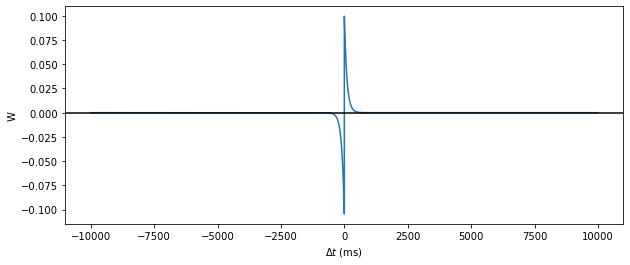

<Figure size 720x288 with 0 Axes>

In [9]:
# --- STDP théorique ---------------------------------------------------------------------------------------------------------------------------------------------------------------
tau_pre = tau_post = 100*ms
A_pre = 0.1
A_post = -A_pre*1.05
delta_t = linspace(-10000, 10000, 20000)*msecond

w_stdp = where(delta_t>=0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
    
plt.figure(figsize=(10,4))
plot(delta_t/ms, w_stdp)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');
    
plt.figure(figsize=(10,4))
plt.scatter(delta_T/ms, w_per_spike_pair)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');
print(w_per_synapse_list)

In [10]:
def synchro_detector_terminator(Ni, e_true, e_in, delta_w, N):
    
    start = time.time()
    
    tau_pre = tau_post = 100*ms
    A_pre = 0.1
    A_post = -A_pre*1.05
    # --- STDP entre e_in et e_true ----------------------------------------------------------------------------------------------------------------------------------------------------
    
    e_in.sort(key=lambda y: y[1]) #pour trier de N
    e_true.sort(key=lambda y: y[1]) #pour trier de tmin à tmax
    
    delta_T = []
    comparaison = []
    delta_T_comp = []
    w_per_spike_pair = [] #shape(Nj,Ni)
    w_per_spike_pair_with_comp = []
    w_per_synapse_mean = {}
    
    
    for i in range(len(e_in)):
        for k in range(len(e_true)):  
            comparaison.append(tuple((e_in[i][1], e_true[k][1]))) #Nj,Ni
            delta_T.append(e_true[k][0]*ms - e_in[i][0]*ms)
    
    for i in range(len(delta_T)):       
        w_per_spike_pair.append((where(delta_T[i]>0, A_pre*exp(-delta_T[i]/tau_pre), A_post*exp(delta_T[i]/tau_post))))
        w_per_spike_pair_with_comp.append(tuple((w_per_spike_pair[i], comparaison[i])))
    print(w_per_spike_pair_with_comp)
    w_per_spike_pair_0 = {}
    w_per_synapse = {}
    w_per_synapse_list = []
    
    for k in range(Nj):
        for c in range(Ni):
            w_per_spike_pair_0[k,c] = []
            
    for i in range(len(w_per_spike_pair_with_comp)):
        for k in range(Nj): 
            for c in range(Ni): 
                if w_per_spike_pair_with_comp[i][1]==(k,c):
                    
                    w_per_spike_pair_0[k,c].append(w_per_spike_pair_with_comp[i][0])
                w_per_synapse[k,c] = sum(w_per_spike_pair_0[k,c])
        
    for k in range(Nj):
        for c in range(Ni):
            w_per_synapse_list.append(w_per_synapse[k,c])
    w_per_synapse_list = np.array(w_per_synapse_list)+np.array(delta_w)
    w_per_synapse_list = np.nan_to_num(w_per_synapse_list, -.1*10e-50)
    
    print('synchro_detector time : ', time.time() - start)
    
    return w_per_synapse_list


### learn

In [11]:
def learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma):
    
    start = time.time()
    
    delta_e_in = []
    delta_e_true = []
    delta_w = {}
    delta_e_out = []
    rapport = {}
    signal = {}
    bruit = {}
    
    for N in range(N_epoch): 
        start_3 = time.time()
        print(N)
        delta_w[N] = []
        i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
        i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 
        
        s, syn, a_spike, b_spike, c_spike, e_in, e_true = quick_generator(Ni, Nj, n_pattern, i_indices, i_temps, i_syn, W, delay, sigma)
        delta_e_in.append(e_in) 
        delta_e_true.append(e_true)
    
        if N == 0 : 
            w_per_synapse_list = synchro_detector_terminator(Ni, delta_e_true[N], delta_e_in[N], 0, N)
            x_s, y_s, z = i_want_to_see_each_sequence (Ni, duration, W, delay, i_syn)

        else : 
            w_per_synapse_list = synchro_detector_terminator(Ni, delta_e_true[N], delta_e_in[N], delta_w[N-1], N)
      
        delta_w[N].append(w_per_synapse_list)
        delta_w[N] = np.reshape(delta_w[N], (1,Ni*Nj))
        print('epoch time: ', time.time() - start_3)
        
    w_ = np.reshape(delta_w[N_epoch-1], (Nj,Ni))     
    start_2 = time.time()
    
    plt.figure(figsize = (10,4))
    for i in delta_e_in[N_epoch-1]:
        plt.scatter(i[0], i[1], marker = '|')

    
    plt.figure(figsize = (10,4))
    for i in delta_e_true[N_epoch-1]:
        plt.scatter(i[0], i[1], marker = '|')

    w_adress = {}
    high_w = {}
    low_w = {}
    n_error = {}
    
    seuil = mean(w_)
    
    for k in range(Ni) :
        w_adress[k] = []
        high_w[k] = []
        low_w[k] = []
       
        for i in s.j[k,:] :  
            if w_[i,k] > seuil : 
                w_adress[k].append(tuple((i, w_[i,k])))
            if s.w[k,i] > 2 and w_[i,k] < seuil : 
                low_w[k].append(tuple((i, w_[i,k])))
            if s.w[k,i] < 2 and w_[i,k] > seuil :
                high_w[k].append(tuple((i, w_[i,k])))
                    
        n_error[k] = len(low_w[k]) + len(high_w[k])
    
    true_adress = {}
    true_weight = {}
    for k in range(Ni):
        true_adress[k] = []
        true_weight[k] = []
        for i in s.j[k,:] :  
            if s.w[k,i] > 2 : 
                true_weight[k].append(s.w[k,i])
                true_adress[k].append(i)
        signal[k] = len(true_adress[k])*len(s.i[k,:])
        bruit[k] = len(delta_e_in[N]) - signal[k] 
        rapport[k] = signal[k]/bruit[k]
        
    n_error_tot = [] 
    ratio_true = []

    for k in range(Ni): 
        n_error_tot.append(n_error[k])
    n_error_tot = sum(n_error_tot)
    ratio_true = 100 - (n_error_tot*100/(Ni*Nj))
   
    
    print('error time : ', time.time() - start_2)
    print('learning time : ', time.time() - start)
    
    print('-------------------------------------------------------------------------------------------------------')
    
    print('signal/bruit : ', rapport)
    print('N_ERROR : ', n_error)
    print('error tot :', n_error_tot)
    print('pourcentage de success :', ratio_true)
    
    return delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_

#### for 1 adress

In [8]:
Ni = 1
N_epoch = 20
n_pattern = 30
duration = 10*second

i_syn=[]
n_syn = []
nn_j = []
W = []
n_j_quick =[]

for k in range(Ni) : 
    n_j = (np.random.randint(3, Nj, size = 1)) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    W.append(list(np.random.rand(int(n_j))))
    W[k] /= sum(W[k])
    i_syn_bruit = np.linspace
n_syn = sum(n_syn) 

# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 

In [12]:
sigma = 6.8*mV 
#si sigma = 6.8, signal/bruit = 1.64, erreur = 0

0
generation time:  39.53763270378113
synchro_detector time :  16.921429872512817
epoch time:  58.72017693519592
1
generation time:  41.920905351638794


KeyboardInterrupt: 

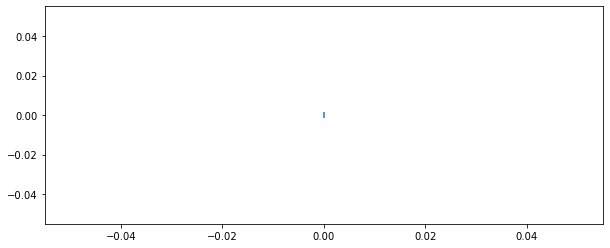

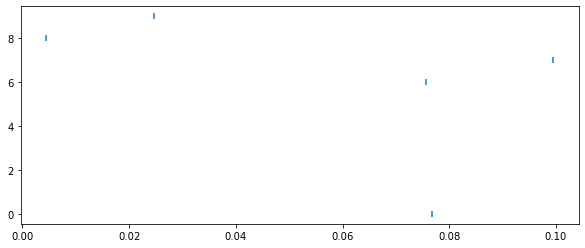

In [15]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [ ]:
sigma = 6.6*mV 
#si sigma = 6.6, signal/bruit = 2.08, erreur = 0

0
generation time:  6.654892921447754


WARNING    "w" is an internal variable of group "synapses_7", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


synchro_detector time :  6.492396116256714


WARNING    "w" is an internal variable of group "synapses_10", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_9", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


epoch time:  14.479403257369995
1
generation time:  11.89741587638855
synchro_detector time :  6.890764951705933
epoch time:  18.788180828094482
2
generation time:  21.606846809387207
synchro_detector time :  6.303563356399536
epoch time:  27.910410165786743
3
generation time:  13.67476201057434
synchro_detector time :  5.305764436721802
epoch time:  18.980526447296143
4
generation time:  17.63654613494873
synchro_detector time :  6.035507440567017
epoch time:  23.687682151794434
5
generation time:  6.9954588413238525
synchro_detector time :  7.2125842571258545
epoch time:  14.208043098449707
6
generation time:  17.267282962799072
synchro_detector time :  7.099842548370361
epoch time:  24.367125511169434
7
generation time:  7.028947114944458
synchro_detector time :  8.008497953414917
epoch time:  15.040444612503052
8
generation time:  6.709117412567139
synchro_detector time :  6.97809910774231
epoch time:  13.687216520309448
9
generation time:  6.994607925415039
synchro_detector time :

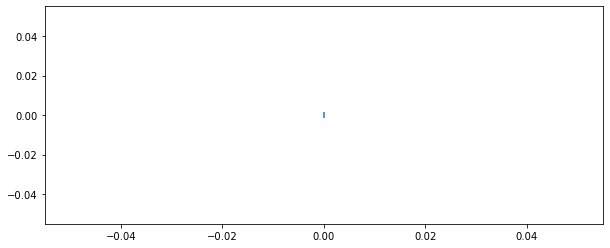

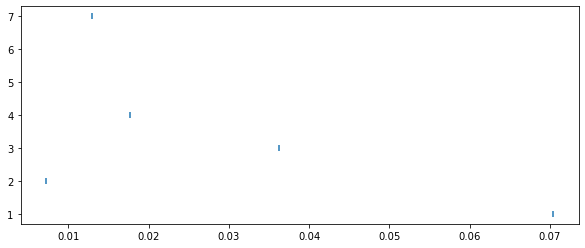

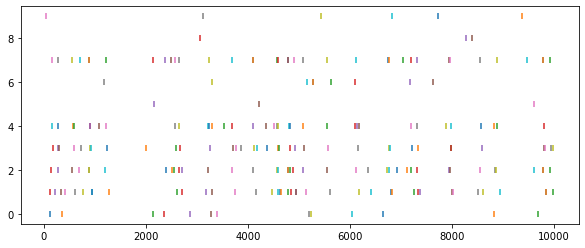

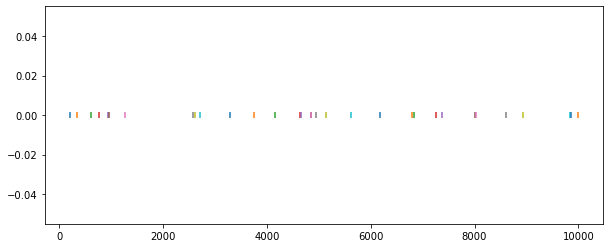

In [867]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [868]:
sigma = 7*mV 
#si sigma = 7, signal/bruit = 1.35, erreur = 0  

0
generation time:  6.5847251415252686
synchro_detector time :  10.034078121185303


WARNING    "w" is an internal variable of group "synapses_4", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


epoch time:  24.538236141204834
1
generation time:  12.35585880279541
synchro_detector time :  10.91538143157959
epoch time:  23.286869764328003
2
generation time:  7.0844480991363525
synchro_detector time :  9.442265033721924
epoch time:  16.54233980178833
3
generation time:  7.723116636276245
synchro_detector time :  9.912126779556274
epoch time:  17.63824486732483
4
generation time:  6.634418487548828
synchro_detector time :  14.190662622451782
epoch time:  20.84129285812378
5
generation time:  24.478024005889893
synchro_detector time :  12.497048139572144
epoch time:  36.975072145462036
6
generation time:  7.182501316070557
synchro_detector time :  10.252087593078613
epoch time:  17.43744158744812
7
generation time:  6.854228973388672
synchro_detector time :  10.070564985275269
epoch time:  16.929797887802124
8
generation time:  6.858738660812378
synchro_detector time :  8.831801176071167
epoch time:  15.690539836883545
9
generation time:  18.761619567871094
synchro_detector time :

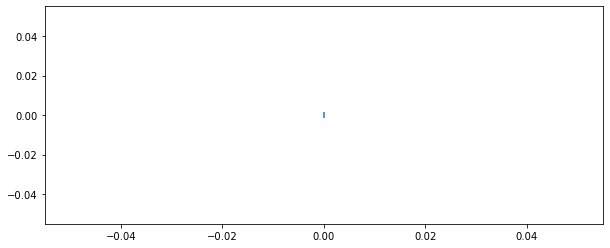

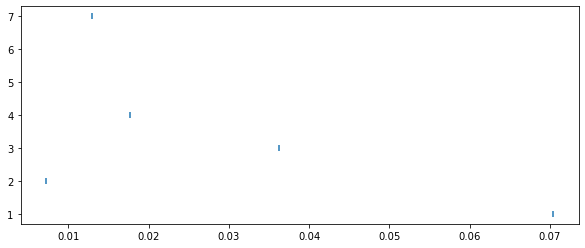

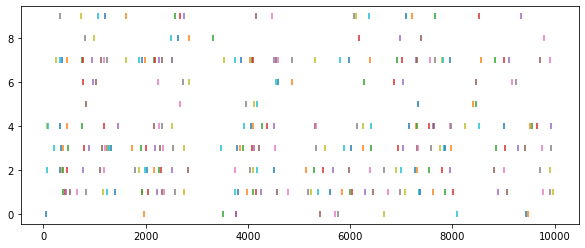

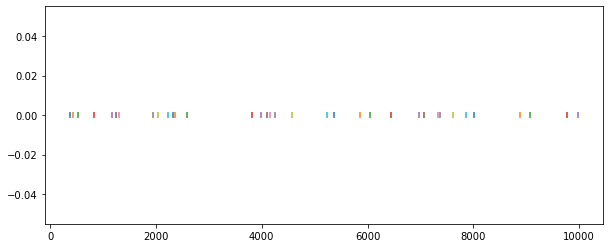

In [869]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [872]:
sigma = 7.2*mV 
#si sigma = 7.2, signal/bruit = 0.97, erreur = 0  

0
generation time:  38.10245108604431
synchro_detector time :  13.350646495819092
epoch time:  53.17203330993652
1
generation time:  16.114929914474487
synchro_detector time :  14.2892746925354
epoch time:  30.41983389854431
2
generation time:  6.712575912475586
synchro_detector time :  13.852452039718628
epoch time:  20.565027952194214
3
generation time:  6.783845901489258
synchro_detector time :  12.151999473571777
epoch time:  18.951475381851196
4
generation time:  6.7225260734558105
synchro_detector time :  15.708948612213135
epoch time:  22.431474685668945
5
generation time:  6.925501585006714
synchro_detector time :  11.61913776397705
epoch time:  18.544639348983765
6
generation time:  6.884862422943115
synchro_detector time :  13.531684875488281
epoch time:  20.416547298431396
7


WARNING    "tau" is an internal variable of group "neurongroup_22", but also exists in the run namespace with the value 200.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


generation time:  56.13559341430664
synchro_detector time :  22.846314668655396
epoch time:  78.98958492279053
8
generation time:  17.437673807144165
synchro_detector time :  14.446591138839722
epoch time:  31.889264822006226
9
generation time:  6.561024188995361
synchro_detector time :  15.808473348617554
epoch time:  22.369497537612915
10
generation time:  6.903636693954468
synchro_detector time :  13.4322350025177
epoch time:  20.351503372192383
11
generation time:  7.011195421218872
synchro_detector time :  16.851972103118896
epoch time:  23.878777980804443
12
generation time:  29.106603145599365
synchro_detector time :  14.175925016403198
epoch time:  43.28252816200256
13
generation time:  6.846564531326294
synchro_detector time :  16.700616121292114
epoch time:  23.547180652618408
14
generation time:  6.522515773773193
synchro_detector time :  14.703827142715454
epoch time:  21.226342916488647
15
generation time:  7.383992910385132
synchro_detector time :  12.822822570800781
epoc

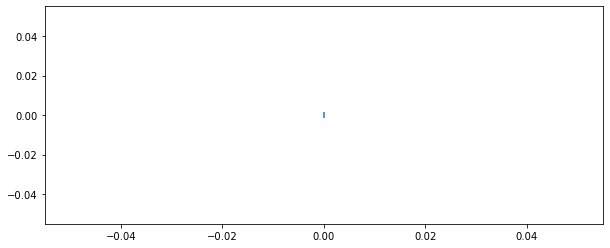

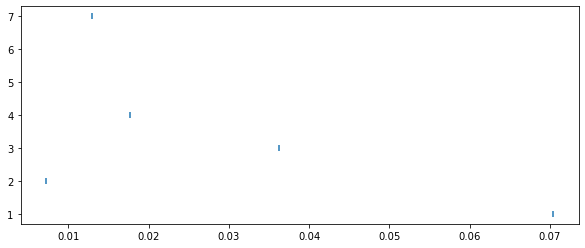

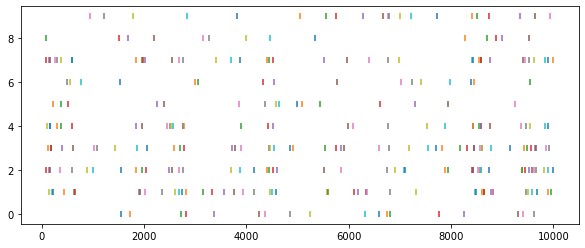

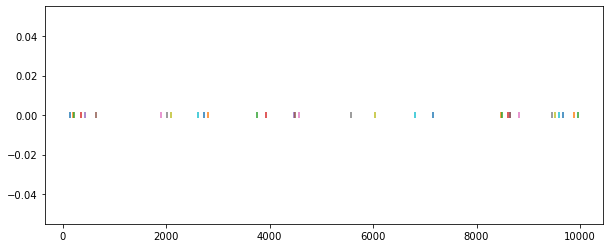

In [873]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [875]:
sigma = 7.5*mV 
#si sigma = 7.5, signal/bruit = 0.7, erreur = 0  

0
generation time:  6.818748712539673
synchro_detector time :  26.297375917434692
epoch time:  41.78898286819458
1
generation time:  10.648134469985962
synchro_detector time :  23.938983917236328
epoch time:  34.6077516078949
2
generation time:  6.730904579162598
synchro_detector time :  26.753488540649414
epoch time:  33.48545503616333
3
generation time:  6.7620930671691895
synchro_detector time :  18.195468425750732
epoch time:  24.957561492919922
4
generation time:  23.59331703186035
synchro_detector time :  24.399442672729492
epoch time:  47.992759704589844
5
generation time:  6.9088239669799805
synchro_detector time :  28.02103304862976
epoch time:  34.92985701560974
6
generation time:  13.786365270614624
synchro_detector time :  35.54052019119263
epoch time:  49.34251523017883
7
generation time:  6.566901922225952
synchro_detector time :  25.6912043094635
epoch time:  32.27375864982605
8
generation time:  6.534993410110474
synchro_detector time :  19.78425645828247
epoch time:  2

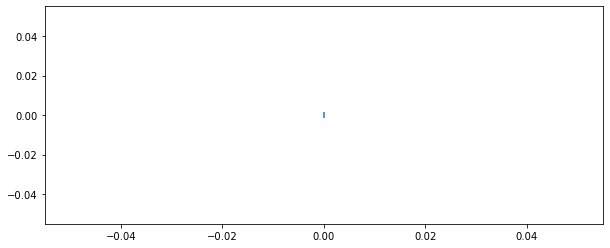

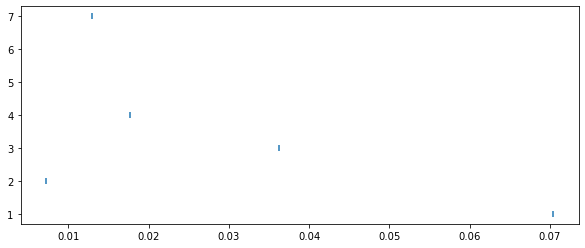

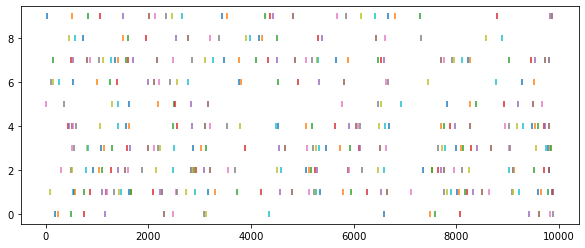

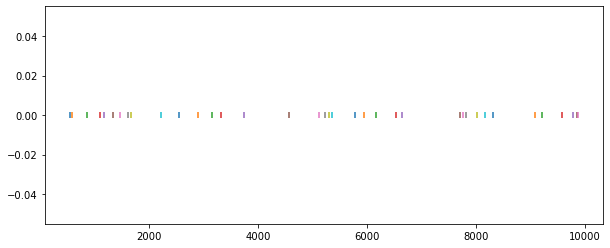

In [876]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [877]:
sigma = 7.8*mV 
#si sigma = 7.8, signal/bruit = 0.5, erreur = 0  

0


WARNING    "w" is an internal variable of group "synapses_11", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_12", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


generation time:  72.23665833473206
synchro_detector time :  106.26618766784668


WARNING    "w" is an internal variable of group "synapses_6", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


epoch time:  181.87019062042236
1


WARNING    "w" is an internal variable of group "synapses_13", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_8", but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


generation time:  49.310099363327026
synchro_detector time :  68.28832864761353
epoch time:  117.6225357055664
2
generation time:  31.679999113082886
synchro_detector time :  89.87982439994812
epoch time:  121.5758638381958
3
generation time:  39.16188955307007
synchro_detector time :  115.58691692352295
epoch time:  154.76478028297424
4
generation time:  54.544925689697266
synchro_detector time :  86.78095602989197
epoch time:  141.34189319610596
5
generation time:  44.09603238105774
synchro_detector time :  65.78645181655884
epoch time:  109.92248606681824
6
generation time:  12.41949987411499
synchro_detector time :  76.72402548789978
epoch time:  89.1671769618988
7
generation time:  46.142587423324585
synchro_detector time :  53.23537492752075
epoch time:  99.38050293922424
8
generation time:  11.448421955108643
synchro_detector time :  116.183513879776
epoch time:  127.66617226600647
9
generation time:  11.597978115081787
synchro_detector time :  82.60970759391785
epoch time:  94.

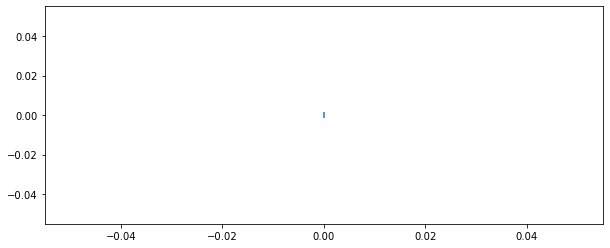

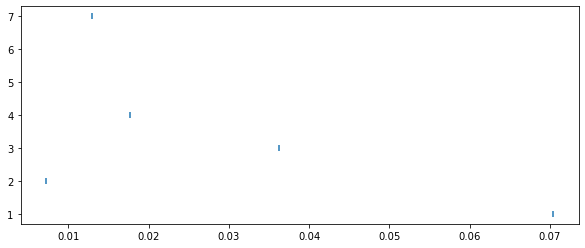

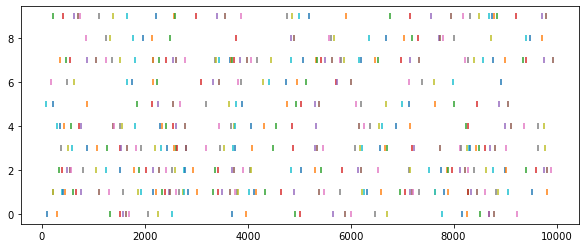

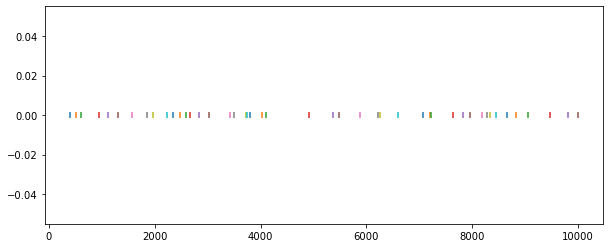

In [879]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [880]:
sigma = 8*mV 
#si sigma = 8, signal/bruit = 0.51, erreur = 0  

0
generation time:  29.93894910812378
synchro_detector time :  60.03486371040344
epoch time:  91.32719588279724
1
generation time:  34.9538733959198
synchro_detector time :  75.12287712097168
epoch time:  110.09109997749329
2
generation time:  7.197530031204224
synchro_detector time :  64.79874229431152
epoch time:  72.00812268257141
3
generation time:  28.621217489242554
synchro_detector time :  100.96997475624084
epoch time:  129.60519361495972
4
generation time:  23.53147864341736
synchro_detector time :  84.05845594406128
epoch time:  107.60656523704529
5
generation time:  14.840114116668701
synchro_detector time :  94.0293619632721
epoch time:  108.88147687911987
6
generation time:  7.422046422958374
synchro_detector time :  65.7762930393219
epoch time:  73.20734095573425
7
generation time:  6.638518810272217
synchro_detector time :  46.2637722492218
epoch time:  52.9187388420105
8
generation time:  8.106265306472778
synchro_detector time :  50.123045682907104
epoch time:  58.2373

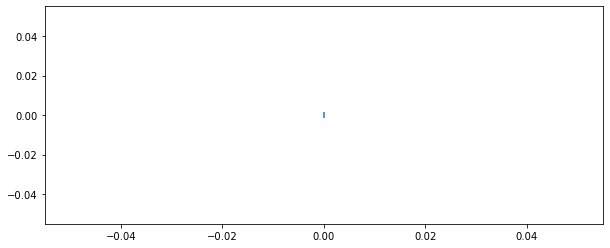

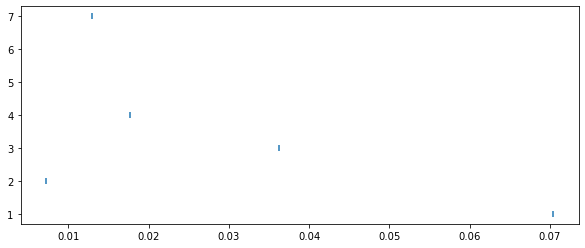

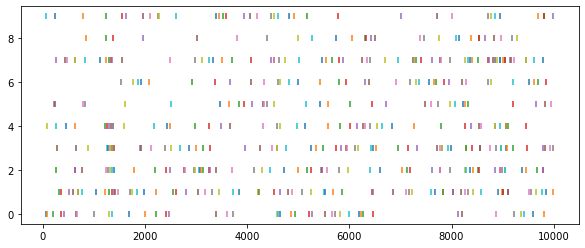

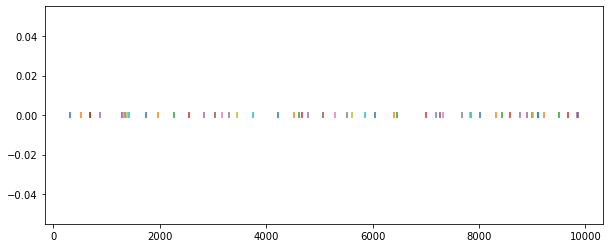

In [881]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [882]:
sigma = 8.3*mV 
#si sigma = 8, signal/bruit = 0.3, erreur = 0  

0
generation time:  10.24259614944458
synchro_detector time :  183.01787900924683
epoch time:  194.9739043712616
1
generation time:  7.3409104347229
synchro_detector time :  131.52626538276672
epoch time:  138.8877251148224
2
generation time:  18.756426572799683
synchro_detector time :  130.79053163528442
epoch time:  149.57922053337097
3
generation time:  12.707942008972168
synchro_detector time :  132.44514322280884
epoch time:  145.16808533668518
4
generation time:  6.955344915390015
synchro_detector time :  99.015944480896
epoch time:  105.99550199508667
5
generation time:  7.993978023529053
synchro_detector time :  140.03700852394104
epoch time:  148.04498863220215
6
generation time:  6.858718395233154
synchro_detector time :  127.68628406524658
epoch time:  134.55800366401672
7
generation time:  18.023077964782715
synchro_detector time :  163.35849261283875
epoch time:  181.40156960487366
8
generation time:  8.29570984840393
synchro_detector time :  156.97262954711914
epoch time:

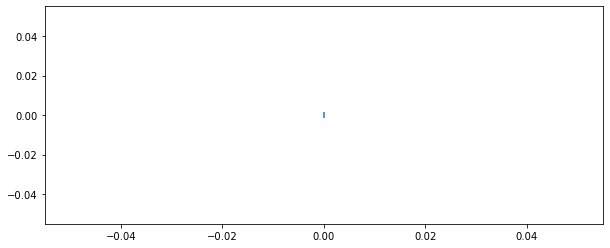

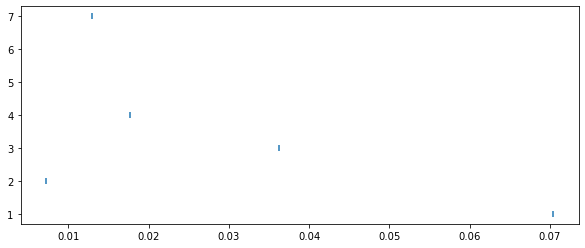

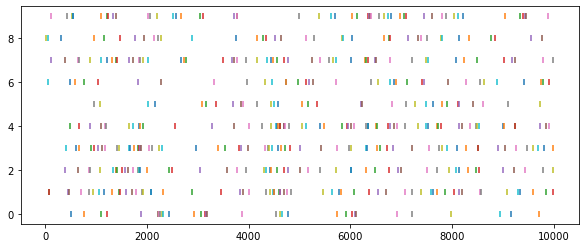

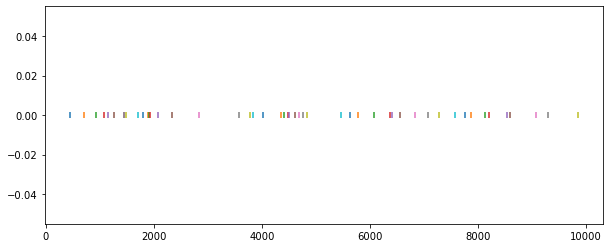

In [883]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

avec un ration signal/bruit = 0.2 (bcp de bruit) on a 1 erreur sur 10
si on augmente le ration signal/bruit (=0.5) on a 0 erreur sur 10 
si on diminue sigma 

#### for several adresses

In [82]:
Ni = 3
N_epoch = 20
n_pattern = 50
duration = 10*second

i_syn=[]
n_syn = []
nn_j = []
W = []
n_j_quick =[]

for k in range(Ni) : 
    n_j = (np.random.randint(3, Nj, size = 1)) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 
    W.append(list(np.random.rand(int(n_j))))
    W[k] /= sum(W[k])
    i_syn_bruit = np.linspace
n_syn = sum(n_syn) 

# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

#weight = np.random.rand(n_syn) # des fois les poids générés pour 1 gp sont trop faibles pour que la detection marche, faudrait il faire en sorte que la somme des poids générés pour 1 gp soit = 1 
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 

but : trouver le rapport signal/bruit minimal pour avoir 0 erreur 
-> 0.05 - 0.15 

In [116]:
sigma = 4*mV 
#si sigma = 4, signal/bruit = 0.05 < 0.15 , erreur = 0

0
generation time:  10.901877641677856
synchro_detector time :  43.55375266075134
each seq time : 2.4372928142547607
epoch time:  56.900925159454346
1
generation time:  12.151339530944824
synchro_detector time :  38.656630754470825
epoch time:  50.82397651672363
2
generation time:  12.229199886322021
synchro_detector time :  22.165109872817993
epoch time:  34.400307178497314
3
generation time:  7.318964242935181
synchro_detector time :  22.097976207733154
epoch time:  29.4229416847229
4
generation time:  7.416731595993042
synchro_detector time :  26.870944261550903
epoch time:  34.2946720123291
5
generation time:  7.770340442657471
synchro_detector time :  28.301201343536377
epoch time:  36.07654619216919
6
generation time:  7.364253044128418
synchro_detector time :  22.6941020488739
epoch time:  30.06435751914978
7
generation time:  17.2197744846344
synchro_detector time :  25.144890308380127
epoch time:  42.367735147476196
8
generation time:  7.279549598693848
synchro_detector time :

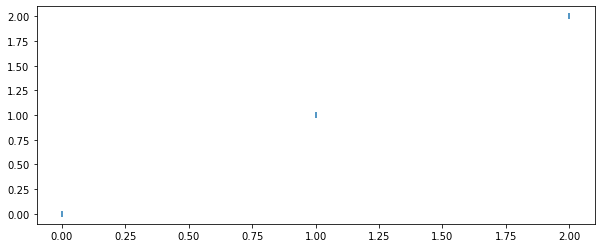

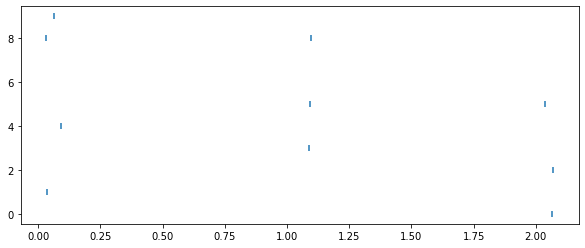

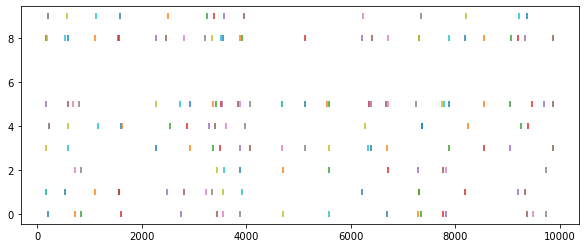

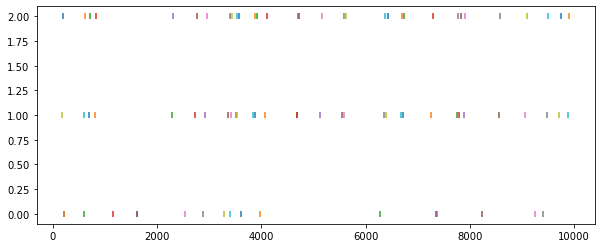

In [117]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [114]:
sigma = 5*mV 
#si sigma = 5, signal/bruit = 0.1 , erreur = 1

0
generation time:  11.64664101600647
synchro_detector time :  50.03830862045288
each seq time : 2.525747060775757
epoch time:  64.23777461051941
1
generation time:  11.699637413024902
synchro_detector time :  44.0953631401062
epoch time:  55.80300164222717
2
generation time:  11.647900104522705
synchro_detector time :  39.92733955383301
epoch time:  51.583237648010254
3
generation time:  11.878498315811157
synchro_detector time :  41.679370403289795
epoch time:  53.565890073776245
4
generation time:  12.184443712234497
synchro_detector time :  44.71784591674805
epoch time:  56.91317629814148
5
generation time:  12.908211469650269
synchro_detector time :  41.47100758552551
epoch time:  54.38722062110901
6
generation time:  12.63711166381836
synchro_detector time :  39.41450095176697
epoch time:  52.056628465652466
7
generation time:  94.44799709320068
synchro_detector time :  47.612224817276
epoch time:  142.06823468208313
8
generation time:  13.373236179351807
synchro_detector time : 

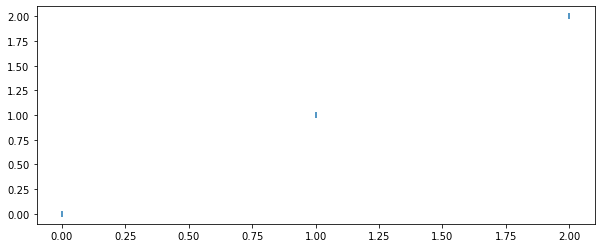

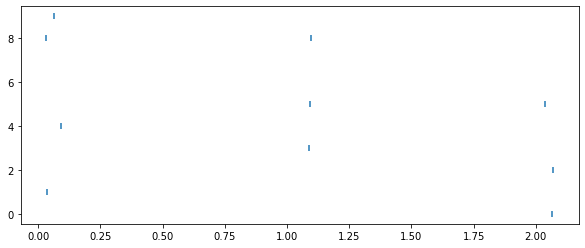

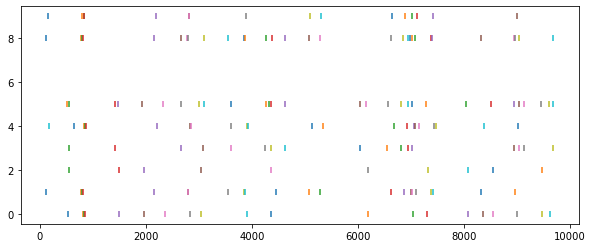

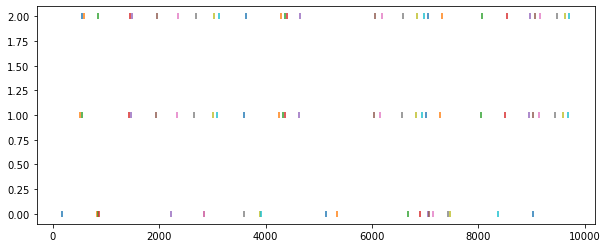

In [115]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [112]:
sigma = 5.8*mV 
#si sigma = 5.8, signal/bruit = 0.1 , erreur = 1

0
generation time:  12.094970226287842
synchro_detector time :  58.58122420310974
each seq time : 2.7290263175964355
epoch time:  73.42121958732605
1
generation time:  23.322829484939575
synchro_detector time :  67.73137259483337
epoch time:  91.07020592689514
2
generation time:  13.314104318618774
synchro_detector time :  72.30600166320801
epoch time:  85.63882970809937
3
generation time:  12.732555389404297
synchro_detector time :  67.99868750572205
epoch time:  80.73924803733826
4
generation time:  12.920433759689331
synchro_detector time :  77.87404346466064
epoch time:  90.81046915054321
5
generation time:  29.537798404693604
synchro_detector time :  65.15668225288391
epoch time:  94.71051931381226
6
generation time:  12.367701292037964
synchro_detector time :  58.438660621643066
epoch time:  70.82236433029175
7
generation time:  12.048258543014526
synchro_detector time :  75.8165123462677
epoch time:  87.88162899017334
8
generation time:  13.51799201965332
synchro_detector time :

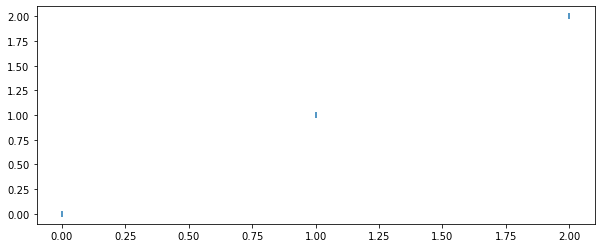

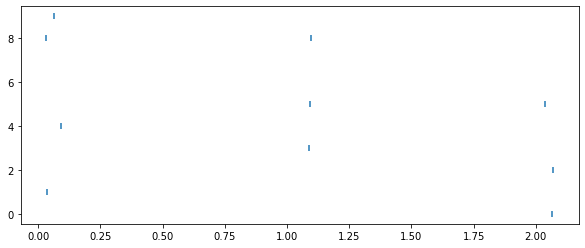

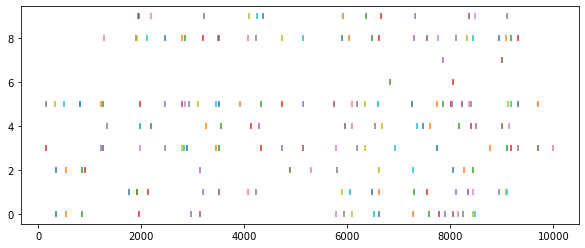

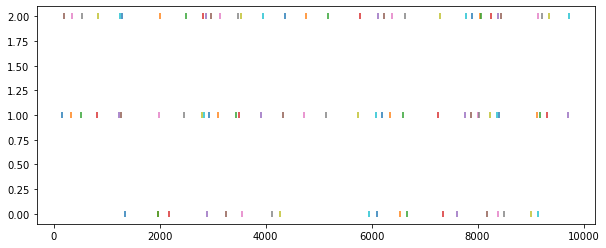

In [113]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [110]:
sigma = 6.3*mV 
#si sigma = 6.3, signal/bruit = 0.1 , erreur = 1

0
generation time:  13.805112600326538
synchro_detector time :  125.45766830444336
each seq time : 36.924453258514404
epoch time:  176.20325088500977
1
generation time:  34.64410066604614
synchro_detector time :  87.55239343643188
epoch time:  122.21251440048218
2
generation time:  12.537951707839966
synchro_detector time :  95.44590926170349
epoch time:  107.999516248703
3
generation time:  21.189399003982544
synchro_detector time :  97.64011192321777
epoch time:  118.84551572799683
4
generation time:  24.052297592163086
synchro_detector time :  106.76307702064514
epoch time:  130.83939242362976
5
generation time:  21.70130681991577
synchro_detector time :  114.73711347579956
epoch time:  136.45217752456665
6
generation time:  12.49931812286377
synchro_detector time :  93.53330826759338
epoch time:  106.05515098571777
7
generation time:  43.107940912246704
synchro_detector time :  107.98887848854065
epoch time:  151.1208176612854
8
generation time:  11.467375040054321
synchro_detector

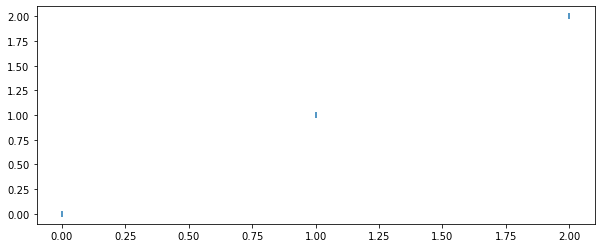

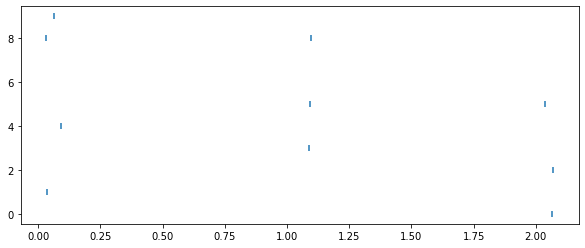

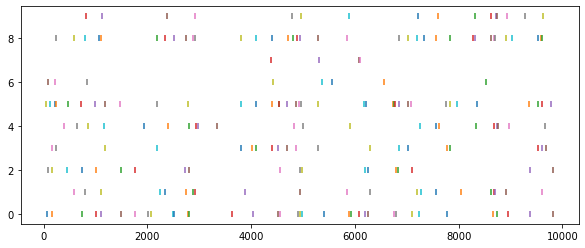

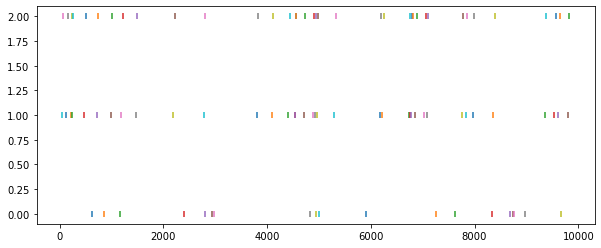

In [111]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [107]:
sigma = 6.6*mV 
#si sigma = 6.6, signal/bruit = < 0.1 , erreur = 1

0
generation time:  20.24880814552307
synchro_detector time :  72.3878915309906
each seq time : 6.458613157272339
epoch time:  99.10254907608032
1
generation time:  7.374343633651733
synchro_detector time :  99.37482810020447
epoch time:  106.76017117500305
2
generation time:  7.874758005142212
synchro_detector time :  95.231290102005
epoch time:  103.12467288970947
3
generation time:  15.284047603607178
synchro_detector time :  102.54578566551208
epoch time:  117.84183406829834
4
generation time:  7.640641927719116
synchro_detector time :  101.5726044178009
epoch time:  109.22424650192261
5
generation time:  7.352193117141724
synchro_detector time :  93.92137026786804
epoch time:  101.28654646873474
6
generation time:  7.290403127670288
synchro_detector time :  83.24205183982849
epoch time:  90.55550527572632
7
generation time:  32.310588359832764
synchro_detector time :  88.09849715232849
epoch time:  120.42008829116821
8
generation time:  7.755736589431763
synchro_detector time :  7

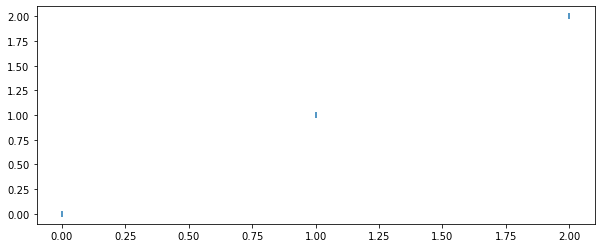

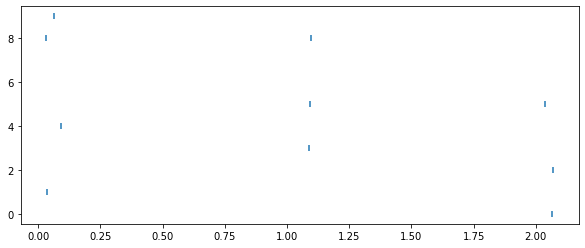

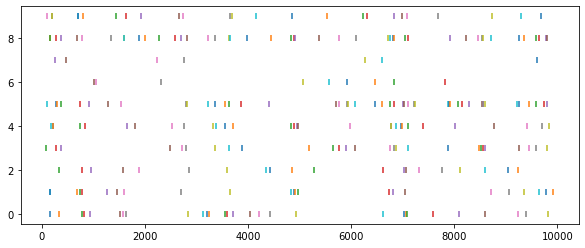

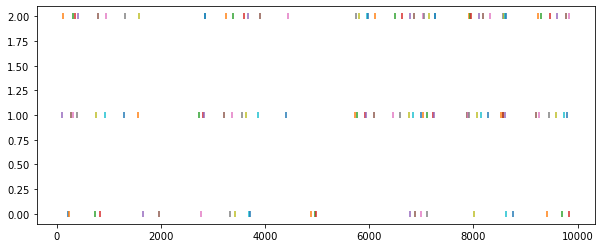

In [108]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adress, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [109]:
sigma = 6.8*mV 
#si sigma = 6.8, signal/bruit = ? , erreur = 1

0
generation time:  7.83595871925354
synchro_detector time :  125.47914409637451


WARNING    "w" is an internal variable of group "synapses_13", but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


each seq time : 28.18353796005249
epoch time:  161.51364135742188
1
generation time:  19.939512968063354
synchro_detector time :  140.39461040496826
epoch time:  160.34523677825928
2
generation time:  28.82438826560974
synchro_detector time :  123.30175518989563
epoch time:  152.13814330101013
3
generation time:  33.19599461555481
synchro_detector time :  135.99292063713074
epoch time:  169.20091438293457
4
generation time:  38.88813304901123
synchro_detector time :  164.94443273544312
epoch time:  203.84756636619568
5
generation time:  33.368263244628906
synchro_detector time :  154.01124119758606
epoch time:  187.3935046195984
6
generation time:  8.170477867126465
synchro_detector time :  127.29425001144409
epoch time:  135.47772979736328
7
generation time:  8.566468477249146
synchro_detector time :  132.10378336906433
epoch time:  140.6832525730133
8
generation time:  32.6893424987793
synchro_detector time :  121.40360283851624
epoch time:  154.10294580459595
9
generation time:  7.5

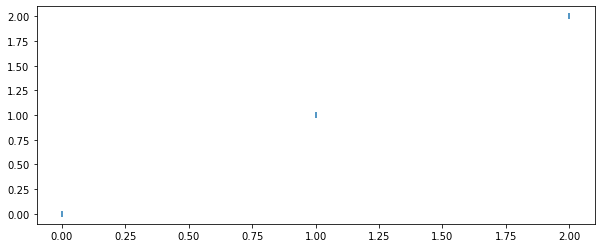

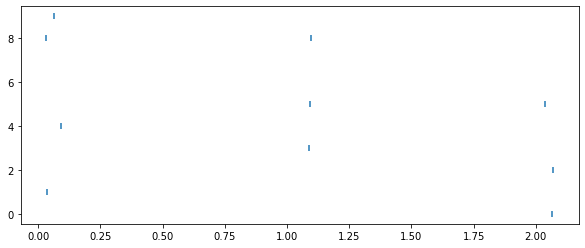

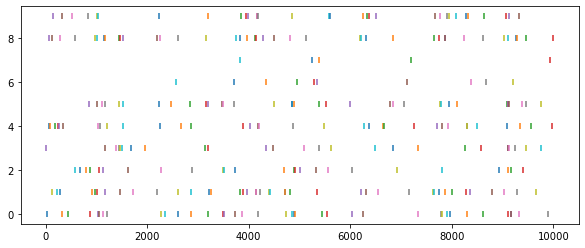

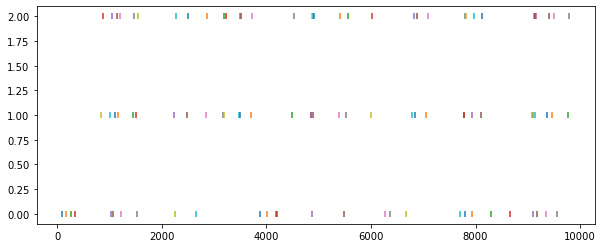

In [88]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adrevss, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [104]:
sigma = 7*mV 
#si sigma = 7, signal/bruit = ? , erreur = 2 

In [ ]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adrevss, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

0


In [100]:
sigma = 7.2*mV 
#si sigma = 7.2, signal/bruit = < 0.05 , erreur = 2

0


WARNING    "w" is an internal variable of group "synapses_14", but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


generation time:  45.08566331863403
synchro_detector time :  247.20450687408447
each seq time : 1.5472040176391602
epoch time:  293.8515648841858
1
generation time:  21.79540991783142
synchro_detector time :  191.9974114894867
epoch time:  213.8077323436737
2
generation time:  8.328438997268677
synchro_detector time :  243.538236618042
epoch time:  251.8823094367981
3
generation time:  33.82439565658569
synchro_detector time :  211.20073461532593
epoch time:  245.17716932296753
4
generation time:  12.780476331710815
synchro_detector time :  311.47374749183655
epoch time:  324.2946536540985
5
generation time:  27.35767698287964
synchro_detector time :  266.07383155822754
epoch time:  293.4505100250244
6
generation time:  8.25392484664917
synchro_detector time :  328.21041083335876
epoch time:  336.48333716392517
7
generation time:  32.9752676486969
synchro_detector time :  220.0663878917694
epoch time:  253.05765771865845
8
generation time:  8.11794638633728
synchro_detector time :  292

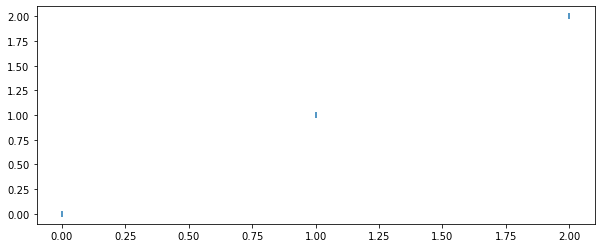

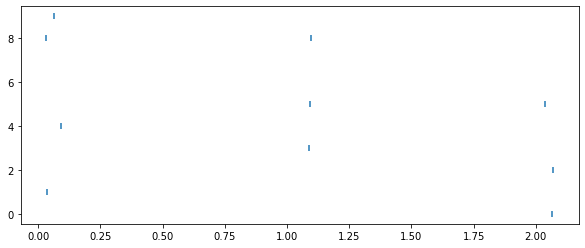

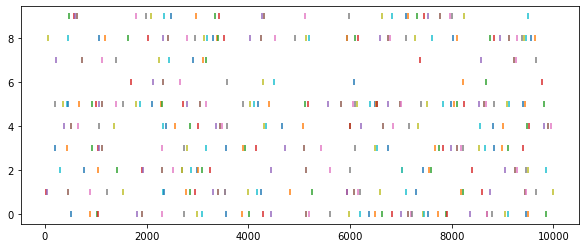

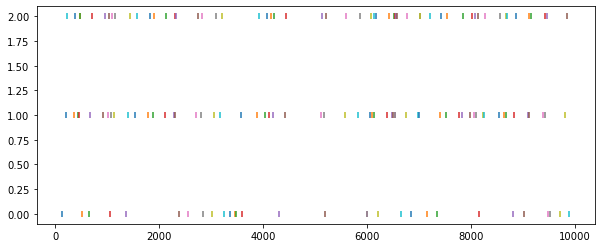

In [101]:
delta_e_out, delta_e_true, delta_e_in, delta_w, s, syn, w, n_error, w_adrevss, true_weight, true_adress, w_ = learn_weight (Ni, Nj, n_pattern, duration, nn_j, i_syn, N_epoch, sigma)

In [806]:
w_adress

{0: [(2, 35.09213904326307),
  (3, 52.20102159438164),
  (6, 44.49359486279839),
  (0, 45.23722604488343),
  (8, 47.26648409481002),
  (5, 48.08215557857355)]}

In [641]:
true_adress = {}
true_weight = {}
for k in range(Ni):
    true_adress[k] = []
    true_weight[k] = []
    for i in s.j[k,:] :  
        if s.w[k,i] > 2 : 
            true_weight[k].append(s.w[k,i])
            true_adress[k].append(i)

## supervised STDP for delay learning

In [278]:
def get_activity (a, Ni, w_adress_, delta_e_in) : 
    #w_adress_ = {}
    nb_syn = {}
    act = {}
    act_t = {}
    act_i = {}
    likelihood = {}
    adresshood = {}
    matrix_adress = {}
    e_in_safe = {}
    w_value = {}
    
    # recup activité des adress d'interet only + les mettre dans la bonne shape pour tanh
    
        #w_value[c] = list(zip(*w_adress[c]))[1]
        #nb_syn[c] = len(w_adress_[c])
        
    delta_e_in.sort(key=lambda y: y[0]) 
    act = list(zip(*delta_e_in))
    act_t = []
    act_i = []
    
    #récup dans deux listes le temps et l'indice de tous les évènement :
    for j in range(Nj): 
        timp = []
        timp_ = []
        for i in range(len(act[1])):
            if act[1][i] == j : 
                timp.append(int(act[0][i]))
                timp_.append(act[1][i])
        act_t.append(timp) # les temps de tous les évènements
        act_i.append(timp_) # les indices de tous les évènements
    
    act_t = np.asarray(act_t)
    act_i = np.asarray(act_i)
    print('act_t :', act_t)
    print('act_i :', act_i)
    print(w_adress_)
        # ne récuperer dans deux liste le t et les i des adresses d'intéret 

    likelihood = {}
    adresshood = {}
    matrix_adress = {}
    activity = {}
            
    for k in range(Ni):
        if a==1 : 
            likelihood[k] = act_t[list(w_adress_[k])] # les temps des évènements des adresses d'intéret only 
            adresshood[k] = act_i[list(w_adress_[k])] # les indices des évènements des adresses d'inétert only 
            print('likelihood :', k, likelihood[k])
            print('adress_hood :', k, adresshood[k])
            
            matrix_adress[k] = {}  
            
            for i in range(len(adresshood[k])):
                matrix_adress[k][i]=[]
                matrix_adress[k][i] = np.ones(len(adresshood[k][i]))*i
                adresshood[k][i] = matrix_adress[k][i].astype('int') #les adress prennent de nouvelles valeurs 
            print('adresshood remasterisée :', adresshood[k])
            
            activity[k] = [[item for sublist in likelihood[k] for item in sublist]] # t giga liste dans activity[0]
            activity[k].append([item for sublist in adresshood[k] for item in sublist])# i giga liste dans activity[1]
            print('activity', activity[k])
            
            activity[k][0], activity[k][1] = zip(*sorted(zip(activity[k][0], activity[k][1])))# dans l'ordre chronologique 
        
            activity[k][0], activity[k][1] = np.array(activity[k][0]), np.array(activity[k][1]) # en np.array
            
        else : 
            likelihood[k] = act_t[w_adress_[k]] # les temps des évènements des adresses d'intéret only 
            adresshood[k] = act_i[w_adress_[k]] # les indices des évènements des adresses d'inétert only 
            likelihood[k] = list(likelihood[k])
            print('likelihood :', k, likelihood[k])
            print('adress_hood :', k, adresshood[k])
            activity[k] = [[likelihood[k]]]
            activity[k].append([adresshood[k]])
            activity[k][0], activity[k][1] = np.array(activity[k][0]), np.array(activity[k][1])
        
    return activity

#### adress 1 by 1 

In [1]:
def learn_delay (Ni, w_adress, delta_e_in, delta_e_true) : 
    d_ = {}
    delta_d = {}
    d_per_synapse_list = {}
    w_adress_ = {}
    for N in range(N_epoch) : 
        
        tuple_activity_in = {}
        tuple_activity_true = {}
        delta_d[N] = {}
        
        for c in range(Ni): 
            w_adress_[c] = list(zip(*w_adress[c]))[0]
        a = 1   
        activity = get_activity (a, Ni, w_adress_, delta_e_in[N])
        print('ACTIVITY_in :', activity)
        print('----------------------------------------------------------------------------------------------------')
        a = 6
        for k in range(Ni): 
            w_adress_[k] = k
        activity_sup = get_activity (a,Ni, w_adress_, delta_e_true[N])
        print('ACTIVITY_sup :', activity_sup)
        for k in range(Ni):
            
            tuple_activity_in[k] = [(activity[k][0][i], activity[k][1][i]) for i in range(0, len(activity[k][0]))]
            tuple_activity_true[k] = [(activity_sup[k][0][i], activity_sup[k][1][i]) for i in range(0, len(activity_sup[k][0]))]
            
        print('tuple_activity_in',tuple_activity_in)
        print('tuple_activity_out', tuple_activity_out)
        for k in range(Ni):
            if N == 0 : 
                d_per_synapse_list[k] = synchro_detector_terminator(Ni, tuple_activity_in[k], tuple_activity_true[k], 0, N)
            else :
                d_per_synapse_list[k] = synchro_detector_terminator(Ni, tuple_activity_in[k], tuple_activity_true[k], delta_d[N-1][k], N)

        delta_d[N] = d_per_synapse_list
        delta_d[N] = np.reshape(delta_d[N], (Ni ,Ni*Nj)) 
            
    for k in range(Ni): 
        d_[k] = np.reshape(delta_d[N_epoch-1][k], (Nj,Ni))
        
    return tuple_activity_in, tuple_activity_true, d_per_synapse_list, delta_d

In [2]:
tuple_activity_in, tuple_activity_true, d_per_synapse_list, delta_d = learn_delay (Ni, w_adress, delta_e_in, delta_e_true)

NameError: name 'Ni' is not defined

In [297]:
np.all?

Signature: np.all(a, axis=None, out=None, keepdims=<no value>, *, where=<no value>)
Docstring:
Test whether all array elements along a given axis evaluate to True.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
axis : None or int or tuple of ints, optional
    Axis or axes along which a logical AND reduction is performed.
    The default (``axis=None``) is to perform a logical AND over all
    the dimensions of the input array. `axis` may be negative, in
    which case it counts from the last to the first axis.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, a reduction is performed on multiple
    axes, instead of a single axis or all the axes as before.
out : ndarray, optional
    Alternate output array in which to place the result.
    It must have the same shape as the expected output and its
    type is preserved (e.g., if ``dtype(out)`` is float, the result
    will consist of 0.0's and 1.0's). See :ref:`ufuncs-out

A FAIRE : 

- lancer learning des poids pour 1 et plusieurs adresses 
        - comparer nb d'erreur
        - comparer nb d'erreur en faisant varier le rapp signal/bruit /!\ avec plusieurs adresses le rapport signal/bruit est faux car les autres sequences sont considérées comme du bruit  
                -> noter ce que variation de sigma entraine précisément 
        - essayer de trouver le meilleur rapport signal/bruit pour avoir le moins d'erreur possible en 1 et plusieurs adresses 
            
- lancer learning supervisé des delais et voir résultats 
- sur le notebook d'antoine : 
        -faire varier B et voir si je peux trouver un truc qui marche
        - faire varier tau aussi 

## unsupervised tanh for delay learning 

In [678]:
stimtime = 2e2
simtime = 1e6
tau = stimtime
B = 1

In [ ]:
class neuron_tanh(object):
    def __init__(self,nb_syn, tau, B):
        self.delays = np.random.randint(0,tau,[nb_syn]).astype(float)
        self.time_diff = np.ones([nb_syn])
        self.tau = tau
        self.B = B
        
    def learn(self, stream):
            timestamp, address = stream[0], stream[1] # timestamp = aer[1] = t des spikes / address = aer[0] = i des spikes 
            #print('how many adress', len(address))
            for ev in range(1,len(address)):
                #self.time_diff += (timestamp[ev]-timestamp[ev-1])
                self.time_diff[address[ev]] = (timestamp[ev]-timestamp[ev-1])  # time_diff[s[s]] , no entiendo lo que passo aqui 
                G = self.B*np.tanh((self.time_diff-self.delays)/self.tau) 
                self.delays += G

In [ ]:
def learn_delays (w_adress, Ni, Nj, N_epoch, delta_e_in, tau, B) :
    start = time.time()
    w_adress_ = {}
    nb_syn = {}
    act = {}
    act_t = {}
    act_i = {}
    likelihood = {}
    adresshood = {}
    matrix_adress = {}
    e_in_safe = {}
    w_value = {}
    # recup activité des adress d'interet only + les mettre dans la bonne shape pour tanh
    for c in range(Ni): 
        w_adress_[c] = list(zip(*w_adress[c]))[0]
        w_value[c] = list(zip(*w_adress[c]))[1]
        nb_syn[c] = len(w_adress_[c])
        
    for epoch in range(N_epoch): 
        delta_e_in[epoch].sort(key=lambda y: y[0]) 
        act[epoch] = list(zip(*delta_e_in[epoch]))
        act_t[epoch] = []
        act_i[epoch] = []
    
    #récup dans deux listes le temps et l'indice de tous les évènement :
        for j in range(Nj): 
            timp = []
            timp_ = []
            for i in range(len(act[epoch][1])):
                if act[epoch][1][i] == j : 
                    timp.append(int(act[epoch][0][i]))
                    timp_.append(act[epoch][1][i])
            act_t[epoch].append(timp) # les temps de tous les évènements
            act_i[epoch].append(timp_) # les indices de tous les évènements
    
        act_t[epoch] = np.asarray(act_t[epoch])
        act_i[epoch] = np.asarray(act_i[epoch])

        # ne récuperer dans deux liste le t et les i des adresses d'intéret 

        likelihood[epoch] = {}
        adresshood[epoch] = {}
        matrix_adress[epoch] = {}
        activity[epoch] = {}
            
        for k in range(Ni):
            likelihood[epoch][k] = act_t[epoch][list(w_adress_[k])] # les temps des évènements des adresses d'intéret only 
            adresshood[epoch][k] = act_i[epoch][list(w_adress_[k])] # les indices des évènements des adresses d'inétert only 
            matrix_adress[epoch][k] = {}      
            for i in range(len(adresshood[epoch][k])):
                matrix_adress[epoch][k][i]=[]
                matrix_adress[epoch][k][i] = np.ones(len(adresshood[epoch][k][i]))*i
                adresshood[epoch][k][i] = matrix_adress[epoch][k][i].astype('int') #les adress prennent de nouvelles valeurs 
        
            activity[epoch][k] = [[item for sublist in likelihood[epoch][k] for item in sublist]] # t giga liste dans activity[0]
            activity[epoch][k].append([item for sublist in adresshood[epoch][k] for item in sublist])# i giga liste dans activity[1]
    
            activity[epoch][k][0], activity[epoch][k][1] = zip(*sorted(zip(activity[epoch][k][0], activity[epoch][k][1])))# dans l'ordre chronologique 
        
            activity[epoch][k][0], activity[epoch][k][1] = np.array(activity[epoch][k][0]), np.array(activity[epoch][k][1]) # en np.array
    
    for c in range(Ni): 
        print('SEQ', c)
        N = neuron_tanh(nb_syn[c], tau, B)
        for epoch in range(N_epoch):
            for i in range(1000):
                N.learn(activity[epoch][c]);
            if epoch == 0  or epoch == N_epoch-1 :
                print('N_epoch : ', epoch)
                plt.scatter(N.delays, w_adress_[c], marker = 'o');
                plt.show()
                
        delay_learn[c]=(N.delays) 
   

    plt.figure(figsize=(10,4))
    plt.scatter(delay_learn[0], w_adress_[0], marker = 'o' )
    plt.scatter([z.delay[0,8]*1e3, z.delay[0,2]*1e3], w_adress_[0], marker = 'x')

    plt.figure(figsize=(10,4))
    plt.scatter(delay_learn[1], w_adress_[1], marker = 'o')
    plt.scatter([z.delay[1,6]*1e3, z.delay[1,5]*1e3, z.delay[1,8]*1e3, z.delay[1,1]*1e3, z.delay[1,3]*1e3, z.delay[1,4]*1e3] , w_adress_[1], marker = 'x')

    plt.figure(figsize=(10,4))
    plt.scatter(delay_learn[2], w_adress_[2], marker = 'o')
    plt.scatter([z.delay[2,8]*1e3, z.delay[2,7]*1e3, z.delay[2,0]*1e3, z.delay[2,4]*1e3], w_adress_[2], marker = 'x')
    
    print('delay learning time :', time.time() - start)
    return delay_learn, act_t, act_i, w_adress_, w_value
        

In [3]:
delay_learn, act_t, act_i, w_adress_, w_value = learn_delays (w_adress, Ni, Nj, N_epoch, delta_e_in, tau, B)

NameError: name 'w_adress' is not defined

## e_out generation with learned weight and delay appris 

In [ ]:
def e_out_generator (Ni, Nj, act_t, act_i, N_epoch, w_adress_, w_value):
    start = time.time()
    
    start_scope()
    
    _in_t = [item for sublist in act_t[N_epoch-1] for item in sublist]
    _in_t_dos = [item for sublist in act_t[N_epoch-1] for item in sublist]
    _in_i = [item for sublist in act_i[N_epoch-1] for item in sublist]
    
    _in_t_safe = []
    _in_i_safe = []
    for i in range(len(_in_t)):
        if _in_t[i] not in _in_t_safe:
            _in_t_safe.append(_in_t[i])
            _in_i_safe.append(_in_i[i])
   
    _in = SpikeGeneratorGroup(10, _in_i_safe, _in_t_safe*ms)
    _in_spike = SpikeMonitor(_in)
    
    _out = NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                                tau : second''',
                        threshold= 'v > 0.05*volt',
                        reset= 'v = 0*volt', 
                        method = 'exact')
    
    _out.v = 0*volt
    _out.tau = 0.001*second
    
    _out_spike = SpikeMonitor(_out)
    
    network = Synapses(_in, _out, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    network.connect(p=1)
    
    network.w[:,:] = np.zeros(3*10)
    
    for c in range(Ni):
        for i in range(len(w_adress_[c])):
            network.w[w_adress_[c][i],c] = w_value[c][i]
            network.delay[w_adress_[c][i],c] = delay_learn[c][i]*second/1000
   
    generator = Network(collect())
    generator.add(_in, _in_spike, _out, _out_spike, network)
    generator.run(duration)       
    #print(network.w)
    print('generation time :',time.time() - start)
    return network, _in_spike, _out_spike

In [ ]:
network, _in_spike, _out_spike= e_out_generator(Ni, Nj, act_t, act_i, N_epoch, w_adress_, w_value)

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(_out_spike.t, _out_spike.i, marker = '|')

In [ ]:
plt.figure(figsize = (10,4))
for i in delta_e_true[N_epoch-1]:
    plt.scatter(i[0], i[1], marker = '|')

In [ ]:
network.delay

# reste

In [306]:
w_adress_ = {}
nb_syn = {}
act = {}
act_t = {}
act_i = {}
likelihood = {}
adresshood = {}
#activity = {}
adresshood = {}
matrix_adress = {}

# recup activité des adress d'interet only + les mettre dans la bonne shape pour tanh
for k in range(Ni): 
    w_adress_[k] = list(zip(*w_adress[k]))[0]
    nb_syn[k] = len(w_adress_[k])

for N in range(N_epoch) : 
    delta_e_in[N].sort(key=lambda y: y[0]) 
    act[N] = list(zip(*delta_e_in[N]))
    act_t[N] = []
    act_i[N] = []
    
    #récup dans deux listes le temps et l'indice de tous les évènement :
    for j in range(Nj): 
        timp = []
        timp_ = []
        for i in range(len(act[N][1])):
            if act[N][1][i] == j : 
                timp.append(int(act[N][0][i]))
                timp_.append(act[N][1][i])
        act_t[N].append(timp) # les temps de tous les évènements
        act_i[N].append(timp_) # les indices de tous les évènements
    
    act_t[N] = np.asarray(act_t[N])
    act_i[N] = np.asarray(act_i[N])

# ne récuperer dans deux liste le t et les i des adresses d'intéret 

    likelihood[N] = {}
    adresshood[N] = {}
    matrix_adress[N] = {}
    activity[N] = {}
    for k in range(Ni): 
        likelihood[N][k] = act_t[N][list(w_adress_[k])] # les temps des évènements des adresses d'intéret only 
        adresshood[N][k] = act_i[N][list(w_adress_[k])] # les indices des évènements des adresses d'inétert only 
        matrix_adress[N][k] = {}      
        for i in range(len(adresshood[N][k])):
            matrix_adress[N][k][i]=[]
            matrix_adress[N][k][i] = np.ones(len(adresshood[N][k][i]))*i
            adresshood[N][k][i] = matrix_adress[N][k][i].astype('int') #les adress prennent de nouvelles valeurs 
        
        activity[N][k] = [[item for sublist in likelihood[N][k] for item in sublist]] # t giga liste dans activity[0]
        activity[N][k].append([item for sublist in adresshood[N][k] for item in sublist])# i giga liste dans activity[1]
    
        activity[N][k][0], activity[N][k][1] = zip(*sorted(zip(activity[N][k][0], activity[N][k][1])))# dans l'ordre chronologique 
    
        activity[N][k][0], activity[N][k][1] = np.array(activity[N][k][0]), np.array(activity[N][k][1]) # en np.array
    
    #activity[N][k] = (activity[N][k][0], activity [N][k][1])


In [ ]:
# je crois que pas besoin de that shit mais je le garde au cas où
real_adresshood= {}
real_activ = {}
real_adresshood[k] = act_i[list(w_adress_[k])] #les i des ev des add d'intéret 
real_activ[k] = [[item for sublist in likelihood[k] for item in sublist]]#en giga liste
real_activ[k].append([item for sublist in real_adresshood[k] for item in sublist])  
real_activ[k][0], real_activ[k][1] = zip(*sorted(zip(real_activ[k][0], real_activ[k][1] )))#dans l'ordre chronologique
real_activ[k][0], real_activ[k][1] = np.array(real_activ[k][0]), np.array(real_activ[k][1]) # en np.array
real_activ[k] = (real_activ[k][0], real_activ[k][1])
print('sorted with real_adresshood', real_activ[k][0], real_activ[k][1])

SEQ 0
N_epoch :  0


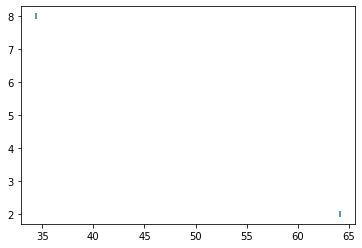

N_epoch :  1
N_epoch :  2
N_epoch :  3
N_epoch :  4
N_epoch :  5
N_epoch :  6
N_epoch :  7
N_epoch :  8
N_epoch :  9


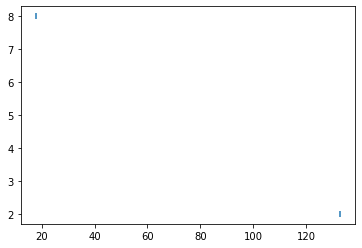

SEQ 1
N_epoch :  0


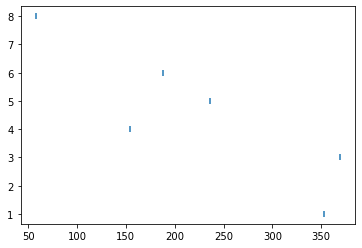

N_epoch :  1
N_epoch :  2
N_epoch :  3
N_epoch :  4
N_epoch :  5
N_epoch :  6
N_epoch :  7
N_epoch :  8
N_epoch :  9


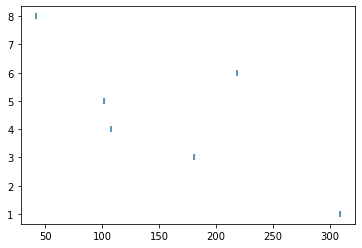

SEQ 2
N_epoch :  0


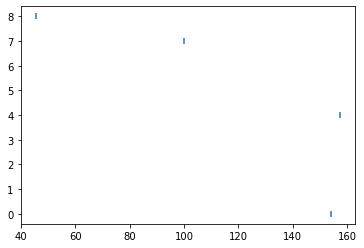

N_epoch :  1
N_epoch :  2
N_epoch :  3
N_epoch :  4
N_epoch :  5
N_epoch :  6
N_epoch :  7
N_epoch :  8
N_epoch :  9


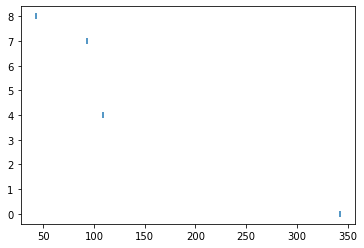

In [357]:
delay_learn={}
adress = {}
    
for c in range(Ni): 
    print('SEQ', c)
    N = neuron_tanh(nb_syn[c], tau, B)
    for epoch in range(N_epoch):
        print('N_epoch : ', epoch)
        for i in range(3000):
            N.learn(activity[epoch][c]);
        if epoch == 0  or epoch == N_epoch-1 :
            plt.scatter(N.delays, w_adress_[c], marker = '|');
            plt.show()
    delay_learn[c]=(N.delays)

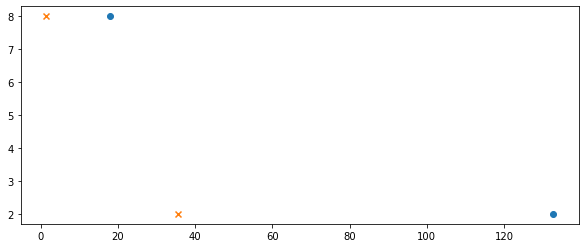

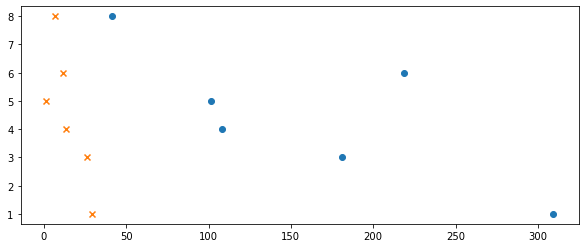

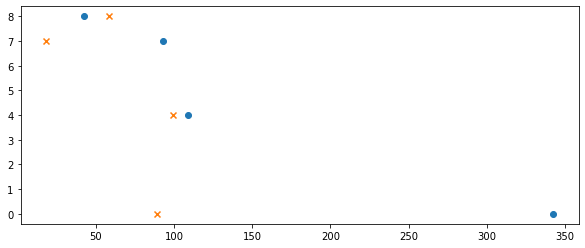

In [390]:
plt.figure(figsize=(10,4))
plt.scatter(delay_learn[0], w_adress_[0], marker = 'o' )
plt.scatter([z.delay[0,8]*1e3, z.delay[0,2]*1e3], w_adress_[0], marker = 'x')

plt.figure(figsize=(10,4))
plt.scatter(delay_learn[1], w_adress_[1], marker = 'o')
plt.scatter([z.delay[1,6]*1e3, z.delay[1,5]*1e3, z.delay[1,8]*1e3, z.delay[1,1]*1e3, z.delay[1,3]*1e3, z.delay[1,4]*1e3] , w_adress_[1], marker = 'x')

plt.figure(figsize=(10,4))
plt.scatter(delay_learn[2], w_adress_[2], marker = 'o')
plt.scatter([z.delay[2,8]*1e3, z.delay[2,7]*1e3, z.delay[2,0]*1e3, z.delay[2,4]*1e3], w_adress_[2], marker = 'x')

IndexError: index 50 is out of bounds for axis 0 with size 50

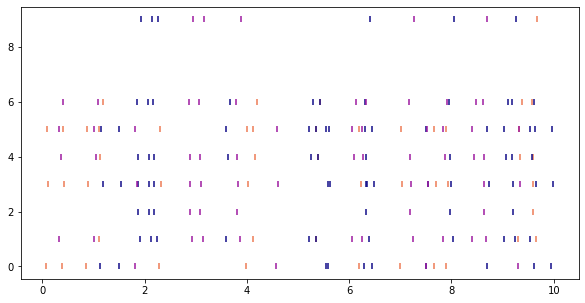

In [ ]:
plot_generator(PGs_pattern)
title('e_in')

Text(0.5, 1.0, 'e_out')

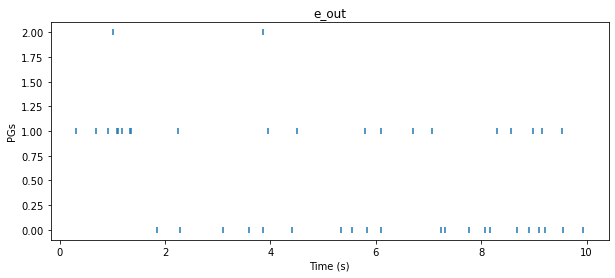

In [97]:
plt.figure(figsize = (10,4))
plt.scatter(e_spike.t, e_spike.i, marker = '|')
xlabel('Time (s)')
ylabel('PGs')
title('e_out')

#c'est ok pour PGs 0 et 2, STDP apprend un poid élever pour la synaspe du dernier Nj a spiker et un faible poid pour les autres
# par contre pour PGs1, la STDP sort un poid max de 2, trop faible. Comment faire pour potentialiser le poid maximum de naps.w[:,2] ? 
# j'ai fais un truc mais je pense pas que ce soit une bonne idée, too much spike ENFAIT SI CA MARCHE C TROP BI1 

Text(0.5, 1.0, 'e_true')

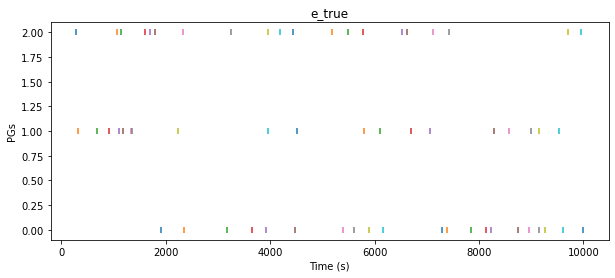

In [101]:
plt.figure(figsize=(10,4))
for i in range(len(delta_e_true[0])) :
    plt.scatter(delta_e_true[0][i][0], delta_e_true[0][i][1], marker = "|")
xlabel('Time (s)')
ylabel('PGs')
title('e_true')

WARNING    C:\Users\camil\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
 [py.warnings]


Text(0.5, 1.0, 'delay PGs')

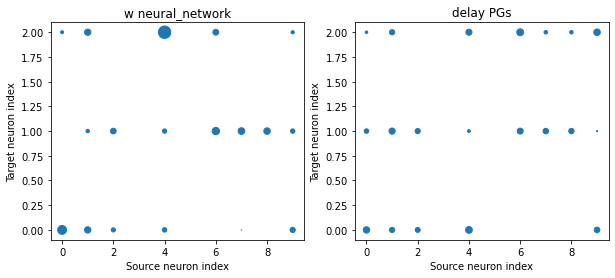

In [21]:
plt.figure(figsize = (10,4))
subplot(121)

scatter(naps.i, naps.j, w_per_synapse_list*10e4)
xlabel('Source neuron index')
ylabel('Target neuron index')
title('w neural_network')

subplot(122)
scatter(s.j, s.i, s.delay*500 )
xlabel('Source neuron index')
ylabel('Target neuron index')
title('delay PGs')

# la STDP donne un poid élevé aux derniers spikes composant un PGs

In [147]:
len(delta_e_in[9])

144

In [ ]:
def neural_network(e_in, w_per_synapse_list):
    start_scope()
    
    PGs_learning = {}
    ind_in = []
    temps_in = []
    thresh = 0.02*volt # /!\

    # --- generation du NN -------------------------------------------------------------------------------------------
    e_in_safe = [] 
    for i in e_in:
        if i not in e_in_safe:
            e_in_safe.append(i)
        
    for i in range(len(e_in_safe)): 
        temps_in.append((e_in_safe[i][0])*ms)
        ind_in.append(e_in_safe[i][1])
        
    d = SpikeGeneratorGroup(Nj, ind_in, temps_in)
    d_spike = SpikeMonitor(d)

    e = NeuronGroup(Ni, ''' dv/dt = -v/tau : volt
                    tau : second''',
                    threshold= 'v > 0.025*volt',
                    reset= 'v = 0*volt',
                    method = 'exact')
    e.v = 0*volt
    e.tau = 0.001*second
    e_spike = SpikeMonitor(e)
 
    naps = Synapses(d, e, on_pre = '''v_post += 0.01*w*volt''', model = '''w:1''')

    naps.connect(p=1)
    
    naps.w[:,:] = w_per_synapse_list
    
    #for i in range(Ni):
      #  if max(naps.w[:,i])*0.01*volt < thresh : 
       #     for j in range(Nj):
        #       if naps.w[j,i]==max(naps.w[:,i]): #np.argmax
        #          naps.w[j,i] = max(naps.w[:,i])*2  #max(w) trop faible pour un PG, donc je fais ça pour compenser mais pas une bonne idée.. 
                           
    run(duration)
    
    PGs_learning = (e_spike.t, e_spike.i)
    e_out = []
    
    for i in range(len(PGs_learning[0])):
        e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
    return e_out, naps, e_spike

In [16]:
start_scope()
e_out, naps, e_spike = neural_network(e_in, np.random.randint(-10,10,Ni*Nj))

## 2nd test

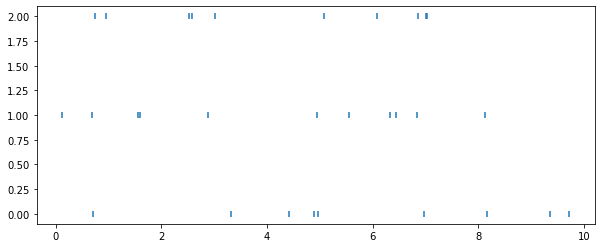

In [92]:
plt.figure(figsize = (10,4))
plt.scatter(a_spike.t, a_spike.i, marker = '|')

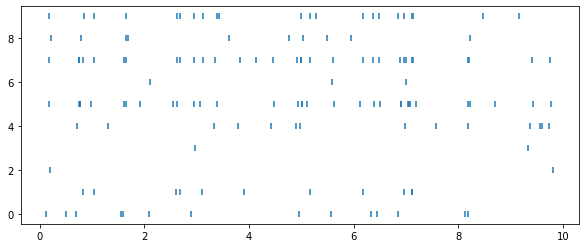

In [118]:
plt.figure(figsize = (10,4))
plt.scatter(b_spike.t, b_spike.i, marker = '|')

In [119]:
len(e_in)

143

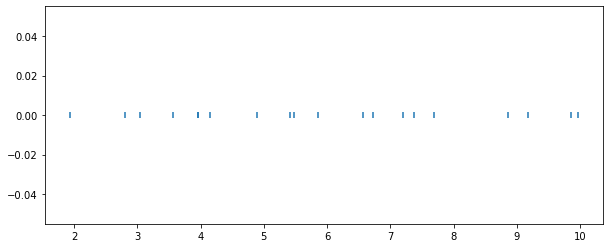

In [470]:
plt.figure(figsize = (10,4))
plt.scatter(c_spike.t, c_spike.i, marker = '|')

In [543]:
def neural_network_2(e_in, w_per_synapse_list, N_epoch):
    start_scope()
    
    start = time.time()
    
    PGs_learning = {}
    ind_in = []
    temps_in = []
    
    random_size = np.random.randint(0,60)
    ind_out = np.random.randint(0, 1, size = random_size) # nombre de PG observé (n_pattern), de Ni sortes différentes
    temps_out = np.random.uniform(0, duration, size = random_size)*second

 
    thresh = 0.02*volt # /!\

    # --- generation du NN -------------------------------------------------------------------------------------------
    e_in_safe = [] 
    for i in e_in:
        if i not in e_in_safe:
            e_in_safe.append(i)
        
    for i in range(len(e_in_safe)): 
        temps_in.append((e_in_safe[i][0])*msecond)
        ind_in.append(e_in_safe[i][1])
    
    if N_epoch == 0 : 
        
        print('ind_out : ',ind_out)
        print('temps_out : ', temps_out)
        e = SpikeGeneratorGroup(Ni, ind_out, temps_out)
        e_spike = SpikeMonitor(e)
        
        run(duration)
        
        PGs_learning = (e_spike.t, e_spike.i)
        e_out = []
    
        for i in range(len(PGs_learning[0])):
            e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
        print('NN time - epoch 0 : ', time.time() - start)

        return e_out, e_spike
        
    else : 
        
        d = SpikeGeneratorGroup(Nj, ind_in, temps_in, dt = 10*usecond)
        d_spike = SpikeMonitor(d)

        e = NeuronGroup(1, ''' dv/dt = -v/tau : volt
                    tau : second''',
                    threshold= 'v > 0.0200*volt',
                    reset= 'v = 0*volt',
                    method = 'exact')
        e.v = 0*volt
        e.tau = 0.001*second
        e_spike = SpikeMonitor(e)
    
        naps = Synapses(d, e, on_pre = '''v_post += 0.01*w*volt''', model = '''w:1''', dt = 1*usecond)

        naps.connect(p=1)
 
        naps.w[:,:] = w_per_synapse_list
   
        run(duration)
    
        PGs_learning = (e_spike.t, e_spike.i)
        e_out = []
    
        for i in range(len(PGs_learning[0])):
            e_out.append(tuple((round(PGs_learning[0][i]*1000/second), PGs_learning[1][i])))
        
        print('NN time : ', time.time() - start)

        return e_out, naps, e_spike

In [519]:
e_out, naps, e_spike = neural_network_2(delta_e_in[19], naps.w, N_epoch=1)

WARNING    Note that the synaptic pathway 'synapses_1_pre' will run on the clock of the group 'spikegeneratorgroup_1' using a dt of 1e-06. Either the Synapses object 'synapses_1' or the target 'neurongroup_1' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 1e-06. If in doubt, try to ensure that 'spikegeneratorgroup_1', 'synapses_1', and 'neurongroup_1' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  614.3733601570129


Text(0.5, 1.0, 'e_out')

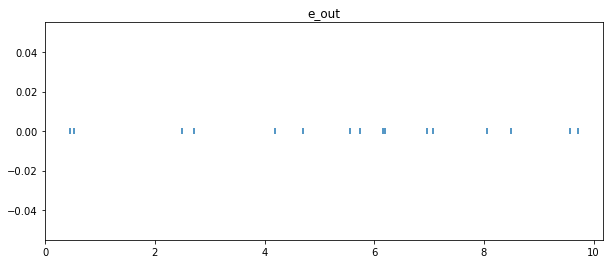

In [531]:
plt.figure(figsize=(10,4))
plt.scatter(e_spike.t, e_spike.i, marker = '|')
title ('e_out')

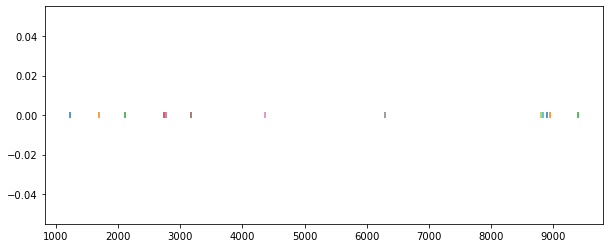

In [530]:
plt.figure(figsize=(10,4))
for i in range(len(delta_e_true[19])):
    plt.scatter(delta_e_true[19][i][0], delta_e_true[19][i][1], marker = '|')

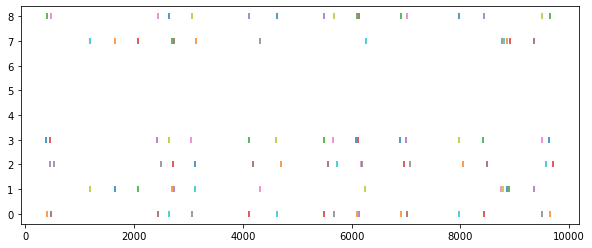

In [534]:
plt.figure(figsize=(10,4))
for i in range(len(delta_e_in[19])):
    plt.scatter(delta_e_in[19][i][0], delta_e_in[19][i][1], marker = '|')

In [540]:
naps.w[1,:]+6

array([-15.47117131])

Text(0.5, 1.0, 'e_in')

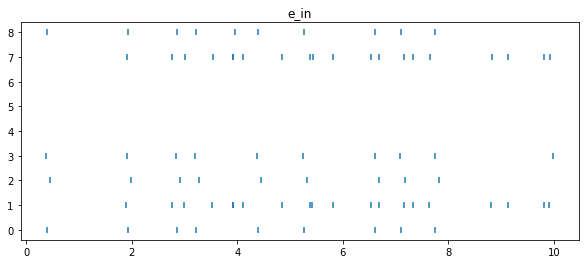

In [532]:
plt.figure(figsize=(10,4))
plt.scatter(b_spike.t, b_spike.i, marker = '|')
title('e_in')

WARNING    C:\Users\camil\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
 [py.warnings]


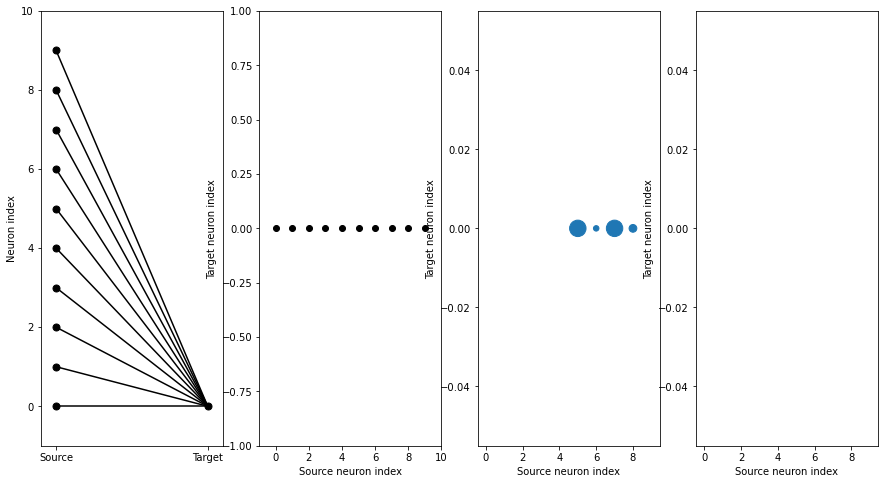

In [487]:
visualise_connectivity(naps)

Text(0.5, 1.0, 'e_true')

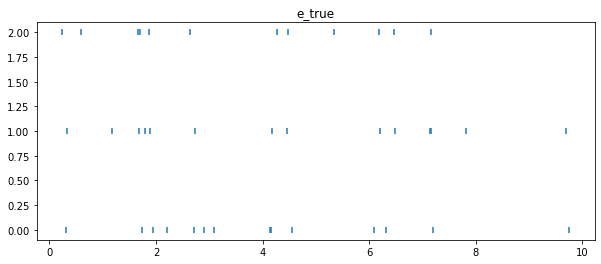

In [247]:
plt.figure(figsize=(10,4))
plt.scatter(c_spike.t, c_spike.i, marker = '|')
title('e_true')

In [424]:
def STDP_with_r(e_in, e_out, e_true, N_epoch):
    
    start = time.time()

    e_true_safe= [ele for ele in e_true if ele != []]
    
    tau_pre = tau_post = 100*ms #même tau pour w_stdp et w_r ? 
    A_pre = 1
    A_post = -A_pre*1.05
    
# === règle homeostasique =====================================================================================================================

    len_e_true = {}
    len_e_out = {}
    w_homéo = {}
    
    for i in range(Ni):
        len_e_true[i] = []
        len_e_out[i] = []
        w_homéo[i] = []
        for k in e_true_safe :
            if k[1]==i : 
                len_e_true[i].append(k[1])
        for k in e_out:
            if k[1]==i : 
                len_e_out[i].append(k[1])
        if len(len_e_true[i])>len(len_e_out[i]) :
            w_homéo[i] = 0.1
        if len(len_e_true[i])<len(len_e_out[i]) :
            w_homéo[i] = -0.1
        if len(len_e_true[i])==len(len_e_out[i]) :
            w_homéo[i] = 0 
            
    print('w_homéo :', w_homéo)    
        
            
# === STDP entre e_in et e_out =================================================================================================================
    
    # --- delta_T entre chaque paire de spike -------------------------------------------------------------------------------------------------
    
    delta_T_STDP = []
    comparaison_STDP = []
    
    for k in range(len(e_out)):
        for i in range(len(e_in)):
            delta_T_STDP.append(e_out[k][0]*ms - e_in[i][0]*ms) #on prend le premier spike de e_out et on le compare avec tous les spikes de e_in (Ni,Nj)
            comparaison_STDP.append(tuple((e_out[k][1], e_in[i][1]))) 
    print('len(delta_T_STDP) :', len(delta_T_STDP))
    # --- def des w_STDP à partir des delta_T e_in/e_out ----------------------------------------------------------------------------------------------------
    
    w_STDP = []        
    for i in range(len(delta_T_STDP)):         
        w_STDP.append(where(delta_T_STDP[i]>0, A_pre*exp(-delta_T_STDP[i]/tau_pre), A_post*exp(delta_T_STDP[i]/tau_post))) #on définit des w pour tous les delta_T, ils sont rangés dans l'ordre e_out_1, e_in_all, e_out_2, e_in_all
    
    # --- visu w_STDP -----------------------------------------------------------------------------------------------------------------------------------
   
    if N_epoch == 0 : 
        plt.figure(figsize=(10,4))
        plt.scatter(delta_T_STDP/ms, w_STDP)
        xlabel(r'$\Delta t$ (ms)')
        ylabel('W')
        axhline(0, ls='-', c='k')
        title (' w_STDP ')
    
# === Def de la variable R e_out/e_true =================================================================================================================
    
    # --- delta_T entre paire de spike du même indice -------------------------------------------------------------------------------------------
    
    delta_T_r = {}
    delta_T_r_plot = []
    for k in range(len(e_out)) :
        delta_T_r[k] = []
        for i in e_true_safe : 
            if i[1] == e_out[k][1] :
                delta_T_r[k].append(i[0]*ms-e_out[k][0]*ms)
                delta_T_r_plot.append(i[0]*ms-e_out[k][0]*ms)
    print('len(delta_T_r) : ', len(delta_T_r))

    # --- def de R à partir des delta_T e_out/e_true ----------------------------------------------------------------------------------------------------------
    
    w_r = {}
    w_r_plot = []
    for i in range(len(delta_T_r)) : 
        w_r[i] = []
        for k in range(len(delta_T_r[i])) : 
            w_r[i].append(where(delta_T_r[i][k]>0, delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_pre)), delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_post)))/second)
            w_r_plot.append(where(delta_T_r[i][k]>0, delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_pre)), delta_T_r[i][k]*exp(-(abs(delta_T_r[i][k])/tau_post)))/second)
        w_r[i] = sum(w_r[i])   
        
    # --- visu r ----------------------------------------------------------------------------------------------------------------------------------------------------
    
    if N_epoch == 0 : 
        plt.figure(figsize=(10,4))
        plt.scatter(delta_T_r_plot/ms, w_r_plot)
        xlabel(r'$\Delta t$ (ms)')
        ylabel('W')
        axhline(0, ls='-', c='k')
        title ('variable R')
    
    
# === Def des delta_w de chaque synapse par w_homéo*R*w_STDP =================================================================================================================
    
    w_STDP_r = {}
    for i in range(len(e_out)):
        w_STDP_r[i] = []
        for k in range(i*len(e_in),(i+1)*len(e_in)) : 
            w_STDP_r[i].append(tuple((w_STDP[k]*w_r[i], comparaison_STDP[k])))
    
    w_syn = {}  
    w_syn_mean = {}
    w_syn_= {}
    for k in range(Nj):
        for c in range(1):
            w_syn[k,c] = []
            
    for a in range(len(e_out)):        
        for i in w_STDP_r[a] :
            for k in range(Nj): 
                for c in range(1): 
                    if i[1]==(c,k):
                        w_syn[k,c].append(i[0])
                    w_syn_mean[k,c] = sum(w_syn[k,c]) #somme 
                    
    w_STDP_r_homéo = {}
    
    for k in w_homéo : 
        for i in w_syn_mean : 
            if k==i[1] :
                    w_STDP_r_homéo[i[0],k] = (w_syn_mean[i])+w_homéo[k]
                
    print('w_STDP_r_homéo :', len(w_STDP_r_homéo), 'w_STDP_r_homéo[0]', w_STDP_r_homéo[0,0])
    w_per_synapse_list = []
    for k in range(Nj):
        for c in range(Ni):
                w_per_synapse_list.append(w_STDP_r_homéo[k,c]) ## pour changer la grandeur, changer Apre/apost et faire la somme plutot que la 
                
    w_per_synapse_list = np.nan_to_num(w_per_synapse_list, -.1*10e-50)
    print('w_per_synapse_list', w_per_synapse_list)
    
    print('W_STDP_r_homéo time : ', time.time() - start)

    return w_per_synapse_list

len(delta_T_STDP) : 10050
len(delta_T_r) :  67
w_r :  67 w_r[0] 0.032652221988282736
w_STDP_r :  67 w_STDP_r[0] [(0.025050978989342988, (2, 8)), (0.03258698280523561, (2, 0)), (-0.030560339463869705, (2, 9)), (-0.030226017869604865, (2, 4)), (-0.024039614465931603, (2, 2)), (-0.022014538419412272, (2, 8)), (-0.015637987843730713, (2, 0)), (-0.013009801987005834, (2, 1)), (-0.012537235700494215, (2, 3)), (-0.010419750298344545, (2, 5)), (-0.0012519509221483273, (2, 8)), (-0.000962427127232761, (2, 0)), (-0.0008561609218850622, (2, 9)), (-0.0008467947600762175, (2, 4)), (-0.0006734800347112154, (2, 2)), (-4.134880181237416e-06, (2, 8)), (-2.937204713429554e-06, (2, 0)), (-2.4435657642705064e-06, (2, 1)), (-2.354806012183456e-06, (2, 3)), (-1.957089364366407e-06, (2, 5)), (-2.589924014675031e-08, (2, 8)), (-2.107765828201994e-08, (2, 8)), (-1.9909831009330207e-08, (2, 0)), (-1.7711490864285906e-08, (2, 9)), (-1.751773209175803e-08, (2, 4)), (-1.62032790185963e-08, (2, 0)), (-1.44141970956

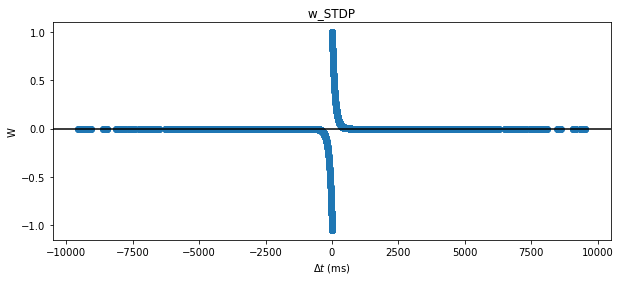

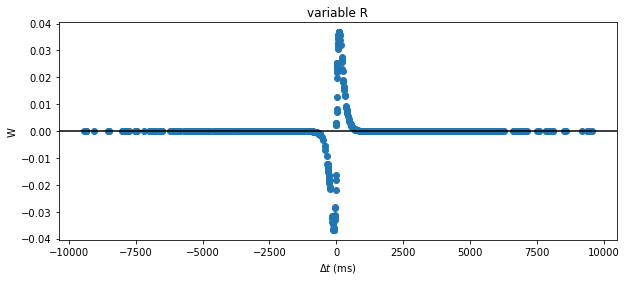

In [392]:
w_per_synapse_list, w_syn_mean = STDP_with_r(e_in, e_out, e_true, 0)

In [546]:
def learn_weight_2 (Ni, n_pattern, duration, nn_j, i_syn):
    
    N_epoch = 20
    
    delta_e_in = []
    delta_e_true = []
    delta_w = []
    delta_e_out = []
    naps_w = []
    
    start = time.time()

    
    for N_epoch in range(N_epoch): 
        
        i_indices = np.random.randint(0, 2, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
        i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 
        
        s, syn, a_spike, b_spike, c_spike, e_in, e_true = quick_generator(2, Nj, n_pattern, i_indices, i_temps)        
        delta_e_in.append(e_in) 
        delta_e_true.append(e_true)
            
        if N_epoch == 0 :
            e_out, e_spike = neural_network_2(delta_e_in[N_epoch], 0, N_epoch)
            delta_e_out.append(e_out)
            
        if N_epoch == 1 : 
            w_per_synapse_list  = STDP_with_r (delta_e_in[N_epoch-1], delta_e_out[N_epoch-1],delta_e_true[N_epoch-1], N_epoch)
            delta_w.append( w_per_synapse_list)
            print('w_per_synapse_list',w_per_synapse_list)
            
            e_out, naps, e_spike = neural_network_2(delta_e_in[N_epoch], np.random.randint(-10,10, Ni*Nj)+delta_w[N_epoch-1], N_epoch)
            print('naps', naps.w) 
            naps_w.append(naps.w)
            delta_e_out.append(e_out)
            
        if N_epoch > 1 :  
            w_per_synapse_list  = STDP_with_r (delta_e_in[N_epoch-1], delta_e_out[N_epoch-1],delta_e_true[N_epoch-1], N_epoch)
            delta_w.append( w_per_synapse_list)
            print('w_per_synapse_list',w_per_synapse_list)
            
            e_out, naps, e_spike = neural_network_2(delta_e_in[N_epoch], naps_w[N_epoch-2]+delta_w[N_epoch-1] , N_epoch)
            print('naps', naps.w) 
            naps_w.append(naps.w)
            delta_e_out.append(e_out)
            
        
         
        print('N_EPOCH :', N_epoch)
    print('TIMETOT', time.time() - start)
    return delta_e_out, delta_e_true, delta_e_in, delta_w, naps_w, naps

In [547]:
 delta_e_out, delta_e_true, delta_e_in, delta_w, naps_w, naps = learn_weight_2 (Ni, n_pattern, duration, nn_j, i_syn)

generation ind : [1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0]
generation temps :  [9.66668726 7.73941165 8.05986031 4.07763216 7.01793265 8.00578367
 5.77609607 1.2946821  7.42308462 3.47446615 6.54832982 6.27489083
 7.30925414 3.30561592 8.24007127 3.89181253 5.46046821 6.2360664
 0.49354372 7.0764072  8.3282525  3.54818782 4.7690712  7.73398015
 4.88133003 2.40237736 5.54754272 5.13373747 9.67641799 0.23361278] s
generation time:  27.469658613204956
ind_out :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
temps_out :  [1.39148569 5.64094834 7.93033046 6.43881646 7.20020613 8.33860742
 9.68078186 3.65428106 0.42460784 8.17870072 2.74962823 3.595446
 3.14308306 1.73807066] s
NN time - epoch 0 :  2.8321657180786133
N_EPOCH : 0
generation ind : [1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0]
generation temps :  [2.91284496 9.13823955 7.63795322 8.2872253  1.73680526 4.13166409
 8.59955475 4.44979682 8.05035058 7.62662426 7.22075961 0.43995405
 6.29217801 5.51962654 0.59705

WARNING    Note that the synaptic pathway 'synapses_3_pre' will run on the clock of the group 'spikegeneratorgroup_3' using a dt of 9.999999999999999e-06. Either the Synapses object 'synapses_3' or the target 'neurongroup_4' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 9.999999999999999e-06. If in doubt, try to ensure that 'spikegeneratorgroup_3', 'synapses_3', and 'neurongroup_4' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  243.95117020606995
naps <synapses_3.w: array([ 2.09114758, -2.00678042,  8.08276682,  1.09226276, -9.9       ,
        2.1       ,  3.1       ,  3.9992088 , -7.90886109, -9.9       ])>
N_EPOCH : 1
generation ind : [1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0]
generation temps :  [6.81252238e-01 4.01384053e-02 7.67855726e+00 3.26591005e+00
 1.71851270e+00 9.50691110e+00 6.10612384e+00 8.74482802e+00
 7.56489247e+00 3.79819389e+00 6.90612366e+00 7.94674339e+00
 2.90872515e+00 8.01409411e+00 2.26759931e+00 1.28405931e+00
 4.35765955e+00 7.39522375e+00 5.90324724e-03 2.58159595e+00
 1.91199108e+00 1.31381793e+00 8.04762525e+00 2.65769790e-01
 3.15472777e+00 9.04939763e+00 1.30602088e+00 3.28150823e-01
 2.15665130e+00 5.87340525e+00] s
generation time:  10.873619556427002
w_homéo : {0: -0.1}
len(delta_T_STDP) : 3000
len(delta_T_r) :  30
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] -0.11538811204375463
w_per_synapse_list [-0.11538811 -0.00560063 -0.21420116 -0.11580269 -0

WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'spikegeneratorgroup_4' using a dt of 9.999999999999999e-06. Either the Synapses object 'synapses' or the target 'neurongroup_7' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 9.999999999999999e-06. If in doubt, try to ensure that 'spikegeneratorgroup_4', 'synapses', and 'neurongroup_7' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  235.5735387802124
naps <synapses.w: array([  1.97575947,  -2.01238104,   7.86856566,   0.97646007,
       -10.        ,   2.        ,   3.        ,   3.75615377,
        -8.02424728, -10.        ])>
N_EPOCH : 2
generation ind : [0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1]
generation temps :  [6.41838961 4.29745775 7.15002324 2.75343054 8.92632299 9.14853398
 6.97585102 8.80627073 0.04827608 8.30216677 1.55988248 8.56050622
 8.87316736 0.99031833 4.55413938 7.88541773 9.8214487  1.70756222
 5.50028268 0.79957602 1.03096602 9.28085227 7.52825836 6.85304386
 0.50599667 1.39435512 0.63291613 5.04833034 1.03496972 4.77081201] s
generation time:  9.89473295211792
w_homéo : {0: -0.1}
len(delta_T_STDP) : 2688
len(delta_T_r) :  28
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] -0.05803629023366457
w_per_synapse_list [-0.05803629  0.12060098 -0.03089635 -0.0659514  -0.1        -0.1
 -0.1        -0.05208173 -0.0579762  -0.1       ]
W_STDP_r_homéo time :  1.335667610168457
w_per

WARNING    Note that the synaptic pathway 'synapses_4_pre' will run on the clock of the group 'spikegeneratorgroup_5' using a dt of 9.999999999999999e-06. Either the Synapses object 'synapses_4' or the target 'neurongroup_8' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 9.999999999999999e-06. If in doubt, try to ensure that 'spikegeneratorgroup_5', 'synapses_4', and 'neurongroup_8' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  239.5848252773285
naps <synapses_4.w: array([  1.91772318,  -1.89178006,   7.8376693 ,   0.91050867,
       -10.1       ,   1.9       ,   2.9       ,   3.70407204,
        -8.08222348, -10.1       ])>
N_EPOCH : 3
generation ind : [0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0]
generation temps :  [0.99149231 3.38943047 8.80892833 4.80471306 3.79834227 8.29435296
 7.83197631 8.40858788 7.62307883 7.16169879 1.79649866 7.35781344
 0.51775725 8.82600244 2.38722219 3.01945071 7.80520496 7.44610523
 3.73911262 3.41401046 1.13825444 8.96291454 9.54381461 5.06295786
 0.64816243 0.19096615 8.08271214 5.85347891 0.63702685 1.72754359] s
generation time:  10.46530032157898
w_homéo : {0: -0.1}
len(delta_T_STDP) : 2820
len(delta_T_r) :  30
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] 0.022272544103936504
w_per_synapse_list [ 0.02227254  0.00213808  0.07641354 -0.01152759 -0.1        -0.1
 -0.1        -0.06065471  0.02252518 -0.1       ]
W_STDP_r_homéo time :  1.359302043914795
w_

WARNING    Note that the synaptic pathway 'synapses_2_pre' will run on the clock of the group 'spikegeneratorgroup_3' using a dt of 9.999999999999999e-06. Either the Synapses object 'synapses_2' or the target 'neurongroup_6' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 9.999999999999999e-06. If in doubt, try to ensure that 'spikegeneratorgroup_3', 'synapses_2', and 'neurongroup_6' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  259.368821144104
naps <synapses_2.w: array([  1.93999572,  -1.88964198,   7.91408284,   0.89898108,
       -10.2       ,   1.8       ,   2.8       ,   3.64341733,
        -8.0596983 , -10.2       ])>
N_EPOCH : 4
generation ind : [1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1]
generation temps :  [3.54627767 1.86477436 1.26578189 9.24840773 9.3893303  6.47388529
 6.36960103 2.92283822 8.59826127 5.97677349 5.51825142 4.89453663
 2.11330112 4.01224734 2.47975478 8.38960093 7.50978483 4.41807141
 6.73183729 4.63614813 4.80833074 2.66146978 0.54083755 0.20948041
 1.86121892 9.02617172 5.03407458 6.54517776 4.31554033 0.7163963 ] s
generation time:  12.728549003601074
w_homéo : {0: -0.1}
len(delta_T_STDP) : 2460
len(delta_T_r) :  30
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] -0.23493432570278747
w_per_synapse_list [-0.23493433  0.14058818 -0.27033888 -0.23811672 -0.1        -0.1
 -0.1        -0.14038195 -0.2349207  -0.1       ]
W_STDP_r_homéo time :  1.3228740692138672
w

WARNING    Note that the synaptic pathway 'synapses_3_pre' will run on the clock of the group 'spikegeneratorgroup_5' using a dt of 9.999999999999999e-06. Either the Synapses object 'synapses_3' or the target 'neurongroup_8' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 9.999999999999999e-06. If in doubt, try to ensure that 'spikegeneratorgroup_5', 'synapses_3', and 'neurongroup_8' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


NN time :  241.28137612342834
naps <synapses_3.w: array([  1.6049943 ,  -1.75491614,   7.56801095,   0.52658564,
       -10.4       ,   1.6       ,   2.6       ,   3.29033806,
        -8.39443898, -10.4       ])>
N_EPOCH : 6
generation ind : [1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0]
generation temps :  [2.25941106 8.44811275 0.53677481 5.22012062 7.756692   8.91236705
 4.55970859 5.66674842 2.64437429 4.2203333  0.35133551 2.2476404
 1.53634496 1.13596605 6.93806306 6.05557552 4.13020513 2.78080116
 0.35283875 6.82198579 7.05778186 3.85834898 1.7161106  8.21672939
 2.2712994  0.07127489 8.2082294  8.87341369 9.77487275 1.37058236] s
generation time:  9.9473237991333
w_homéo : {0: -0.1}
len(delta_T_STDP) : 2639
len(delta_T_r) :  29
w_STDP_r_homéo : 10 w_STDP_r_homéo[0] -0.24936983418564676
w_per_synapse_list [-0.24936983  0.3823807   0.05258841 -0.19849125 -0.1        -0.1
 -0.1        -0.43835082 -0.24940232 -0.1       ]
W_STDP_r_homéo time :  1.4072554111480713
w_p

autre problème : avec la somme je me retrouve avec des valeurs hautes même si elles sont toutes ultra faible (si on en somme bcp ça finit par faire qq chose de grand, après peut etre que ça pause pas de pb si on compare avec les autres, cad que une valeure peut me sembler grande par rapport aux elements qui la compose mais les autres seront plus grandes encore donc blk, but idk) en plus toutes les valeurs finissent par devenir positives
-> solus : faire la moyenne ?

autre problème : mes poids sont bcp trop élevés de façon générale, je me retrouve avec des poids de 129 et tout c nimp 
-> solus : baisser Apre à 1 ou 0.1 

problème, je me demande si le w_homéo est pas trop grand à 1 : ça fait des pas de 1 ou -1 à chaque époque, peut etre mieux de mettre à 0.5 ? 

Prochain truc à faire, garder le naps_w final meme si ça marche bof et on voit si ça marche sur d'autres e_in 

problème : des fois w_stdp*r = 0 mais à cause de w_homéo les poids augmentent quand même
-> solus : mettre w_homéo que si wstdp_r diff de 0 ?
    mauvaise idée, si par malheur le n de spike tombe à 0, il ne remonte jamais la pente 
    
faire des poids entre -5 et 5 

vérifier r

faire ça mais avec une séquence qui se répète et du bruit, le fait que j'ai deux séquences qui se repetent qui fait que ça n'apprend pas 

In [552]:
naps.w

<synapses_2.w: array([ 2.21455488, -1.01603983,  8.58442422,  1.12032318, -9.9       ,
        2.1       ,  3.1       ,  2.07900638, -7.78456644, -9.9       ])>

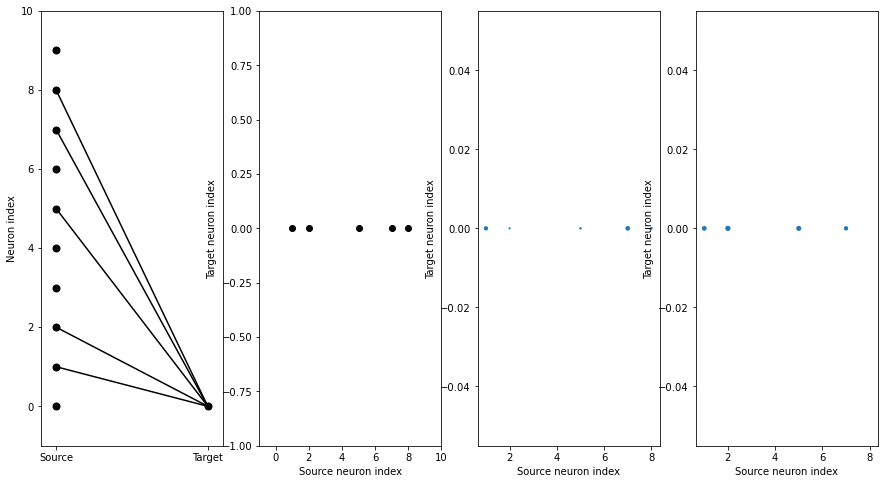

In [556]:
visualise_connectivity(syn)

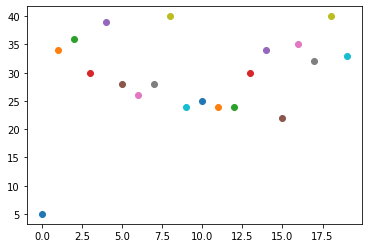

In [502]:
for i in range(len(delta_e_out)):
    plt.scatter(i, len(delta_e_out[i]))

In [507]:
len(delta_e_true[19])

13

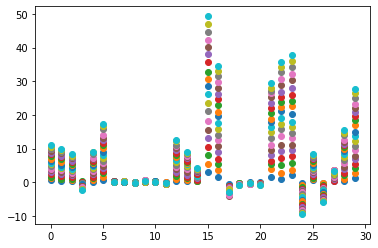

In [150]:
for i in range(len(delta_w)):
    plt.scatter(range(len(delta_w[i][0])), list(delta_w[i]))

In [141]:
len(delta_w[1][0][0])

30

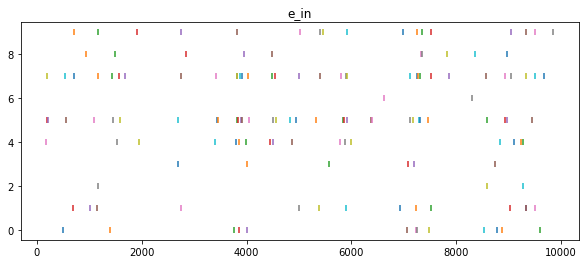

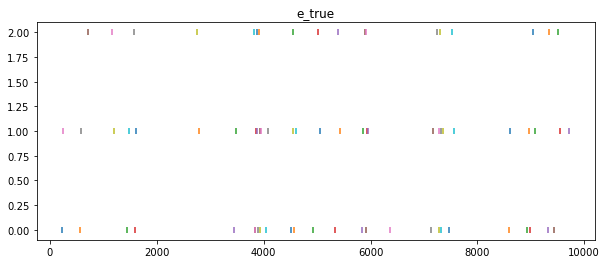

In [152]:
plt.figure(figsize=(10,4))
for i in delta_e_in[16]:
    plt.scatter(i[0], i[1],marker = '|')
    title('e_in')


    
plt.figure(figsize=(10,4))
for i in delta_e_true[16]:
    plt.scatter(i[0], i[1],marker = '|')
    title('e_true')

In [560]:
 len(delta_e_true[16])

19

In [464]:
naps.w[7,0]

array([3.43135649])

In [446]:
delta_e_out[4], delta_e_true[4]

([(448, 0),
  (1083, 0),
  (1239, 0),
  (1803, 0),
  (2334, 0),
  (2536, 0),
  (2864, 0),
  (3527, 0),
  (3727, 0),
  (3894, 0),
  (4509, 0),
  (4843, 0),
  (4871, 0),
  (4936, 0),
  (5369, 0),
  (5616, 0),
  (5681, 0),
  (6226, 0),
  (6647, 0),
  (6728, 0),
  (7109, 0),
  (7205, 0),
  (8388, 0),
  (8412, 0),
  (8838, 0),
  (8936, 0),
  (9034, 0),
  (9074, 0),
  (9720, 0),
  (9725, 0)],
 [(500.90000000000003, 0),
  (1135.3999999999999, 0),
  (1291.4, 0),
  (1855.3000000000002, 0),
  (2386.4, 0),
  (2588.0, 0),
  (2916.5, 0),
  (3579.0, 0),
  (3779.6000000000004, 0),
  (3946.1000000000004, 0),
  (4561.4, 0),
  (4895.8, 0),
  (4923.6, 0),
  (4988.8, 0),
  (5421.200000000001, 0),
  (5668.9, 0),
  (5733.1, 0),
  (6278.700000000001, 0),
  (6699.800000000001, 0),
  (6780.8, 0),
  (7161.5, 0),
  (7257.8, 0),
  (8440.699999999999, 0),
  (8464.7, 0),
  (8890.2, 0),
  (8988.0, 0),
  (9086.800000000001, 0),
  (9126.800000000001, 0),
  (9772.1, 0),
  (9777.300000000001, 0)])

In [410]:
test = []
test_out = []
for i in delta_e_true[0]:
    if i[1]==1 : 
        test.append(i)
print(len(test))
for i in delta_e_out[0]:
    if i[1]==1 : 
        test_out.append(i)
print(len(test_out))

15
13


In [417]:
true_values = np.array([[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]])
predictions = np.array([[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]])

N = true_values.shape[1]
accuracy = {}
for i in range(len(delta_e_out)):
    accuracy[i] = (delta_e_out[i] == delta_e_true[i])

In [ ]:
accuracy = {}
for i in range(N_epoch):
     = (delta_e_out[i] == delta_e_true[i])

31
162
158
148
146
134
124
140
125
120
113
115
105
96
88
93
70
58
55


WARNING    C:\Users\camil\AppData\Local\Temp/ipykernel_23292/710140842.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,4))
 [py.warnings]


64
74
56
53
39
25
51
43
28
11
8


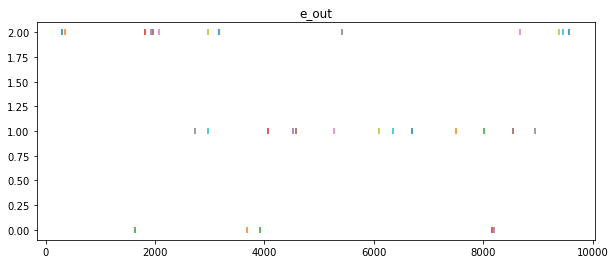

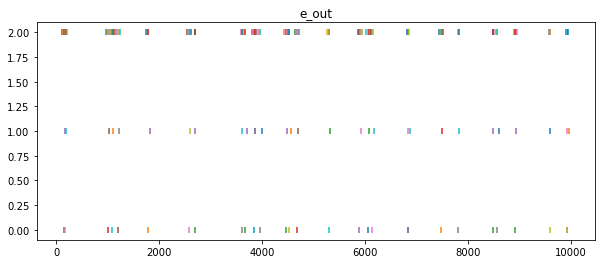

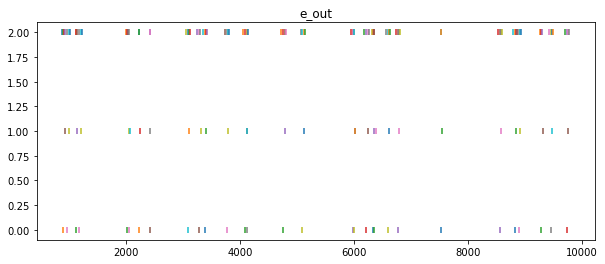

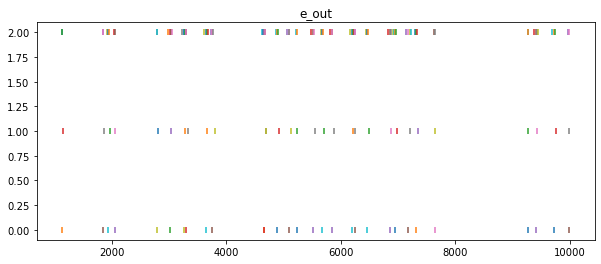

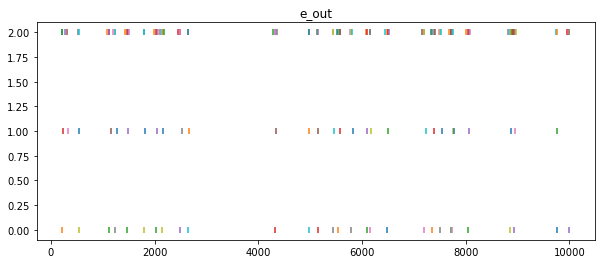

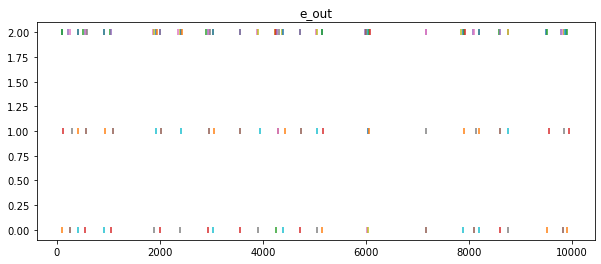

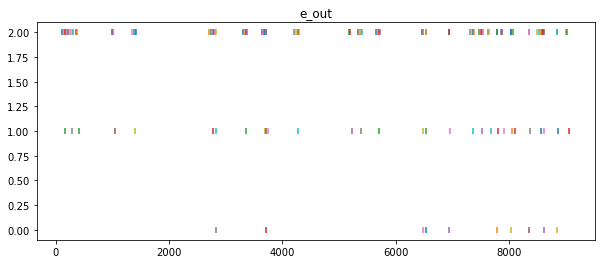

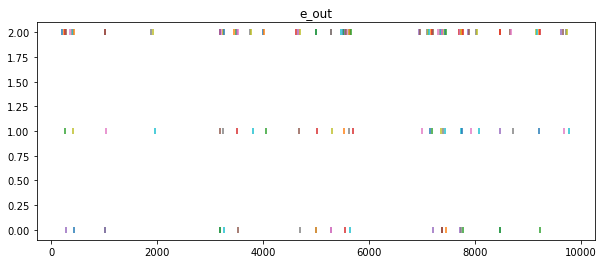

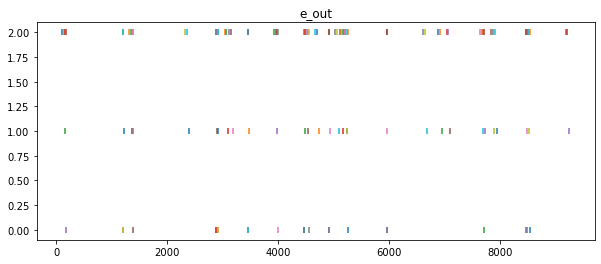

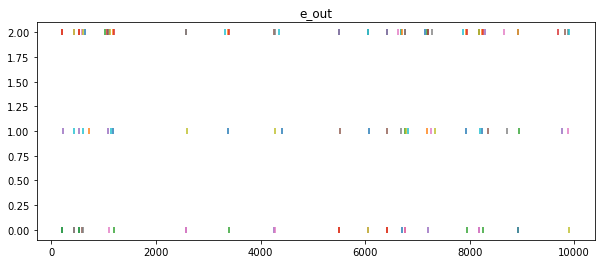

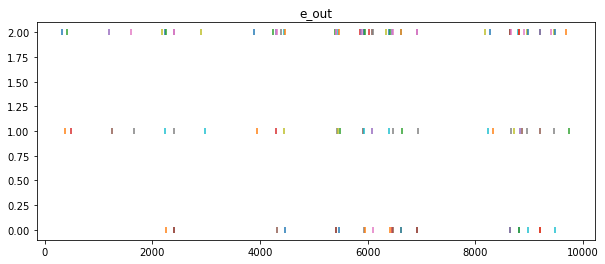

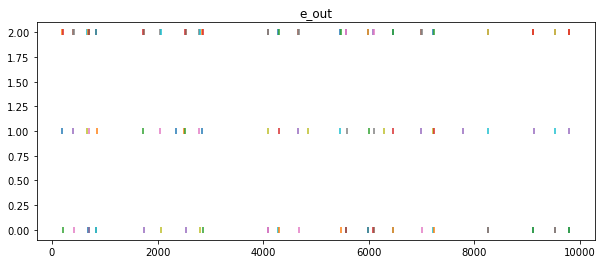

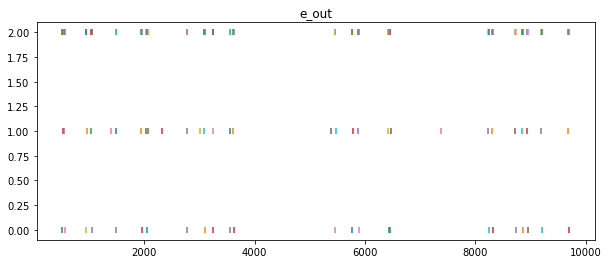

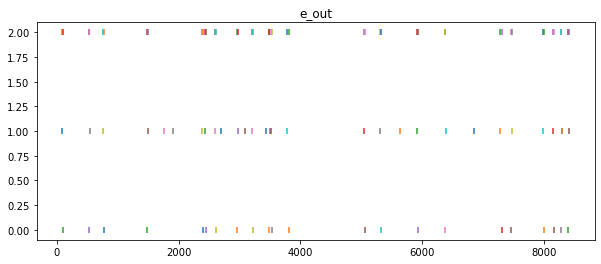

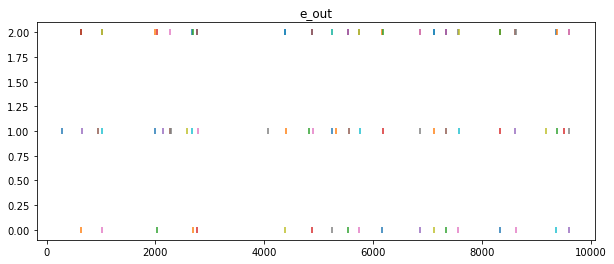

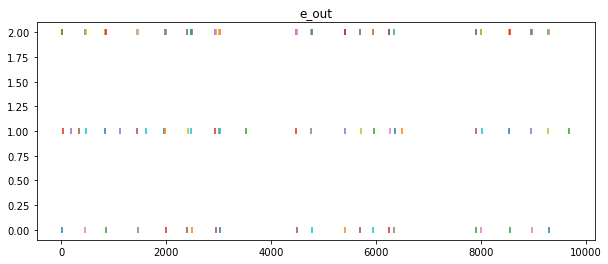

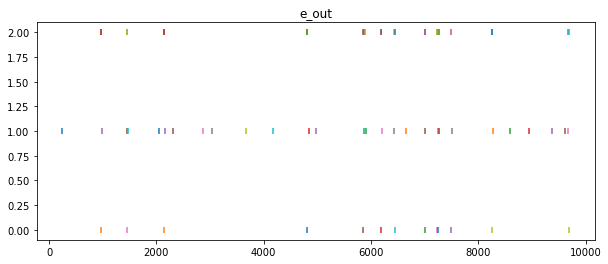

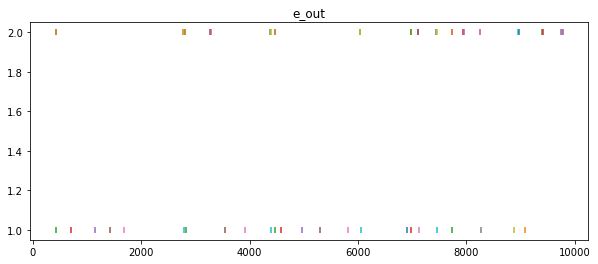

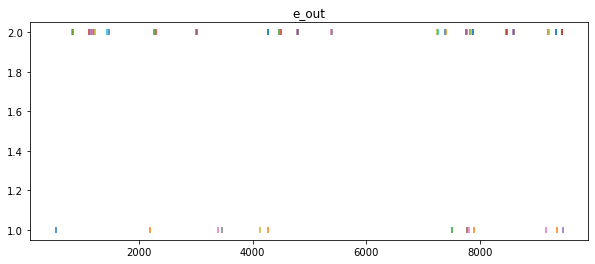

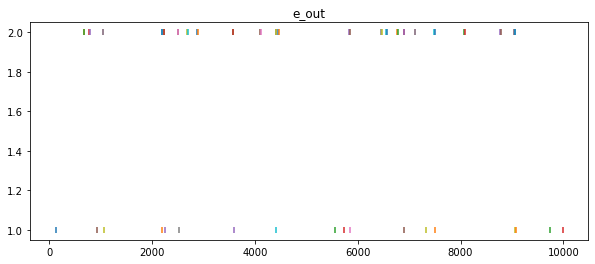

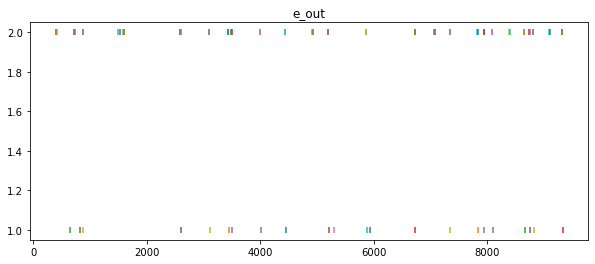

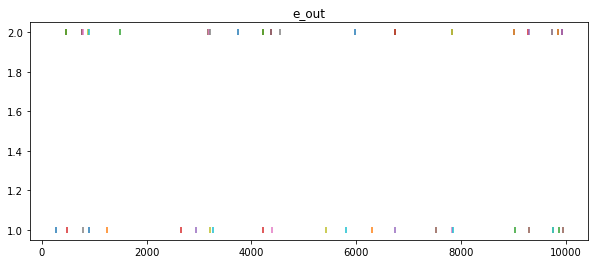

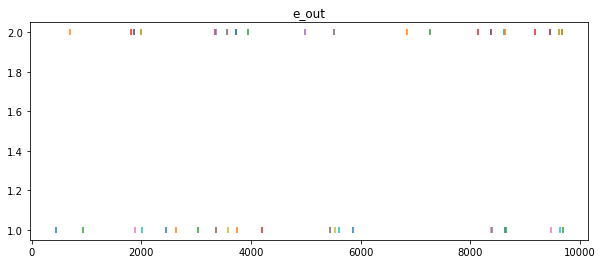

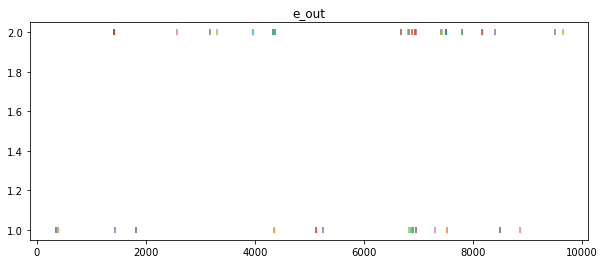

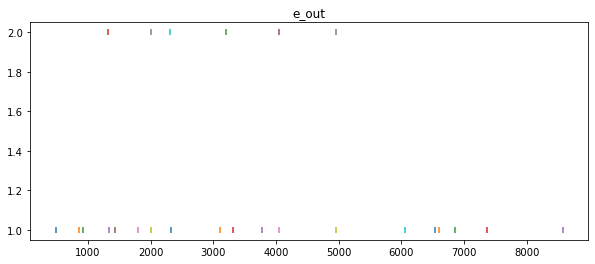

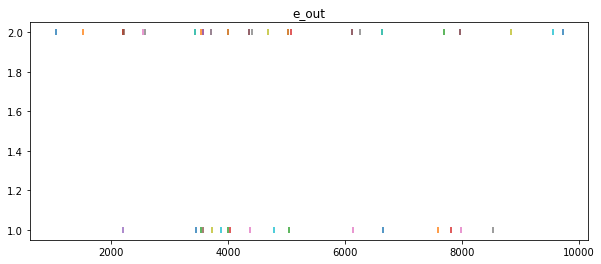

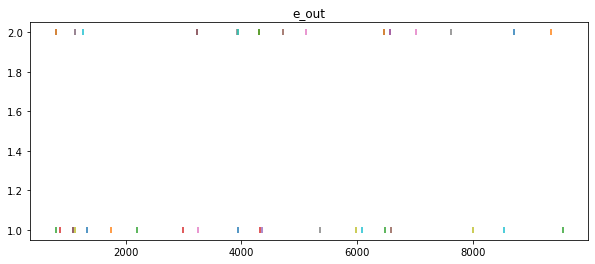

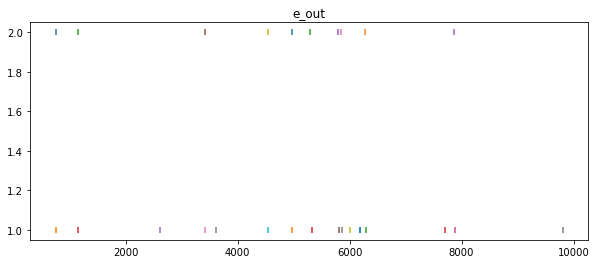

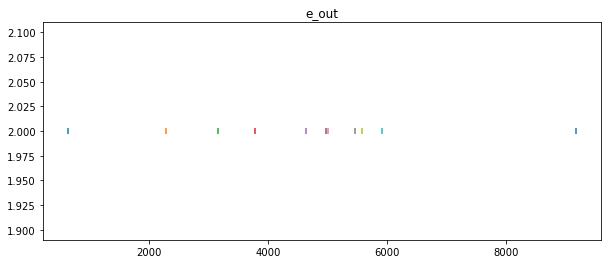

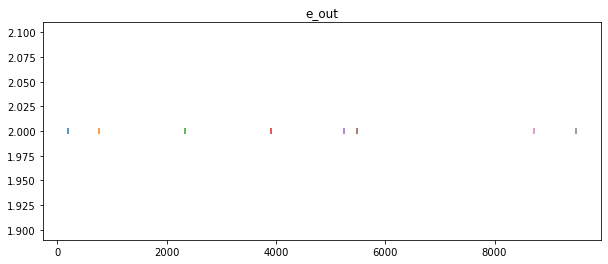

In [411]:
for k in range(len(delta_e_out)):
    plt.figure(figsize = (10,4))
    print(len(delta_e_out[k]))
    for i in delta_e_out[k]: 
        plt.scatter(i[0],i[1], marker = '|')
        title('e_out')

In [ ]:
for k in range(len(delta_e_true)):
    plt.figure(figsize = (10,4))
    for i in delta_e_in[k]: 
        plt.scatter(i[0],i[1], marker = '|')
        title('e_in')

## STDP for delay learning 

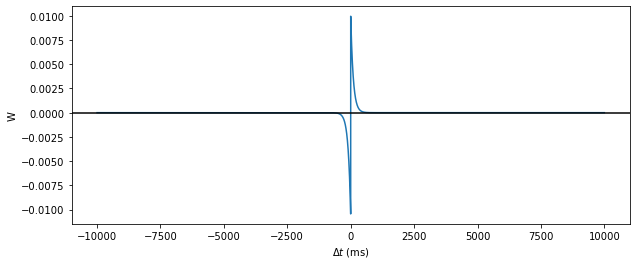

In [23]:
    
    tau_pre = tau_post = 100*ms
    A_pre = 0.01
    A_post = -A_pre*1.05
    delta_t = linspace(-10000, 10000, 20000)*msecond

    w_stdpd = where(delta_t>=0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
    w_stdpd = (w_stdpd)
    
    #w_stdpd = clip(w_stdpd, A_post, A_pre, out = None)
       
    plt.figure(figsize=(10,4))
    plot(delta_t/ms, w_stdpd)
    xlabel(r'$\Delta t$ (ms)')
    ylabel('W')
    axhline(0, ls='-', c='k');

In [ ]:
 def learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False, **kwargs): 
    
        sample = {'e_in': e_in, 'e_true': e_true}
    
        loader = DataLoader(sample, batch_size=batch_size, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
        train_ein_eout_ = neural_network(e_in) #pb : dans logistic_regression on returnait un NN, donc quand on faisait ça, train_ein_eout était un NN, ici c'est un tuple, donc on ne peut pas l'entrainer : what can i do ? 
        train_ein_eout_.to(device)
        train_ein_eout_.train()
    
        optimizer = torch.optim.Adam(train_ein_eout_.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
        for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
       
            train_ein_eout_.train()
            losses = [] 
        
            for e_in_, labels_ in loader: 
                e_in_, labels_ = e_in_.to(device), labels_.to(device)
                outputs = neural_network(e_in_)  
                loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
        
                losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    train_ein_eout.eval()
    e_in_0, labels = torch.Tensor(e_in[:, None]), torch.Tensor(e_true[:, None]) #utile ? 
    e_out = neural_network(e_in_0) #utile ? 
    loss = criterion(e_out, labels).item()
    
    return train_ein_eout, loss
    # --- visualisation ----------------------------------------------------------------------------------------------------------

def plotor(lolo):
    plt.figure(figsize=(10,4))
    plt.scatter(lolo.t, lolo.i, marker = "|")
    
def plotorr(lolo):
    temps_true = []
    ind_true = []
    for i in range(len(e_true)): 
        temps_true.append(e_true[i][0]*ms)
        ind_true.append(e_true[i][1])
        plt.scatter(temps_true[i],ind_true[i])

def plot_weight(lolo):
    plt.figure(figsize=(10,4))
    plot(lolo)
    xlabel('Time (s)')
    ylabel('weight')
    title ('evolution of weight of each synapse')
        
# --- supervised learning ----------------------------------------------------------------------------------------------------------

import torch
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 25 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 1000
n_classes = Nj

def learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False, **kwargs): 
    
    sample = {'e_in': e_in, 'e_true': e_true}
    
    
    loader = DataLoader(sample, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_ein_eout_ = neural_network(e_in)
    train_ein_eout_.train()
    
    optimizer = torch.optim.Adam(train_ein_eout_.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        train_ein_eout_.train()
        losses = [] 
        for e_in_, labels_ in loader: 
            e_in_, labels_ = e_in_.to(device), labels_.to(device)
            outputs = neural_network(e_in_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    train_ein_eout.eval()
    e_in_0, labels = torch.Tensor(e_in[:, None]), torch.Tensor(e_true[:, None]) #utile ? 
    e_out = neural_network(e_in_0) #utile ? 
    loss = criterion(e_out, labels).item()
    return train_ein_eout, loss


In [ ]:
train_ein_eout, loss  = learn_STDP(e_in,e_true, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs, betas=betas,verbose=False)

In [ ]:
plotor(d_spike)
xlabel('Time (s)')
ylabel('neurons')
title('e_in')

In [ ]:
plt.scatter(e_spike.t, e_spike.i)
xlabel('Time (s)')
ylabel('PGs')
title('e_out')

In [ ]:
plot_generator(detection)
xlabel('Time (s)')
ylabel('PGs')
title('e_true')

In [ ]:
visualise_connectivity(naps)

In [ ]:
### la stdp ne semble pas marcher 

In [ ]:
plot_weight(mon.w.T)

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj), naps.w)

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj),mon.w.T[0])

In [ ]:
plt.figure(figsize = (10,4))
plt.scatter(range(Ni*Nj),mon.w.T[100000])

In [ ]:
plot?


In [ ]:
range?

### STDP

In [ ]:
len(w_per_synapse_list)

In [ ]:
w_per_synapse[0,0]

In [ ]:
for i in range(len(w_comp)):
    if w_comp[i][1]==(0,4):
        print(w_comp[i])

In [ ]:
a

In [ ]:
len(e_true)

In [ ]:
w, w_comp = synchro_detector_terminator(e_true, e_in)

In [ ]:
comp = []
delta_ttt = []
delta_tt = []

for i in range(len(e_true)):
    for k in range(len(e_in)):
        comp.append(tuple((e_true[i][1], e_in[k][1])))
        delta_tt.append(e_true[i][0] - e_in[k][0])

In [ ]:
for i in range(len(comp)):
    delta_ttt.append(tuple((delta_tt[i], comp[i])))

In [ ]:
Www = np.zeros((Ni,Nj))
for i in range(len(delta_ttt)):
    for k in range(Ni):
        for c in range(Nj) :
            if delta_ttt[i][1] == (k,c) :
                Www[k][c] == (delta_ttt[i][0])

In [ ]:
Www

In [ ]:
for i in range(len(e_true)): 
    if e_true[i][1]==2:
        print(e_true[i][0])

In [ ]:
for i in range(len(e_in)): 
    if e_in[i][1]==0:
        print(e_in[i][0])

# unsupervised recognition of PGs

In [ ]:
e_true

## detection of temporal patterns 

In [ ]:
all_spike_time

In [ ]:
temps_tot

In [ ]:
# def de ma fenetre temporelle pour reconnaître les PGs
temps_tot = int(duration/msecond)
t_window = 200 #ms
nb_wind = int(temps_tot/t_window)
X = np.zeros((nb_wind, Nj, t_window))

In [ ]:
for k in range(nb_wind) :
    for t,i in (all_spike_time) : 
        if t<t_window : 
            X[1][i][t] = 1 #on peut faire [1,i,t]
            print('ok')
        if t_window*(k-1)<t<t_window*k : 
            X[k][i][t-t_window*(k-1)] = 1 
            print('okk')

In [ ]:
X[

In [ ]:
plot(X[58].T)

In [ ]:
all_spike_time

## cam's k-means